<a href="https://colab.research.google.com/github/Keshvadi/mpcc-dynamics/blob/main/mpcc_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Figure 1: Agent Continuity Time Distribution**

Figure 1 saved to: figures/fig01_continuity_dist.pdf


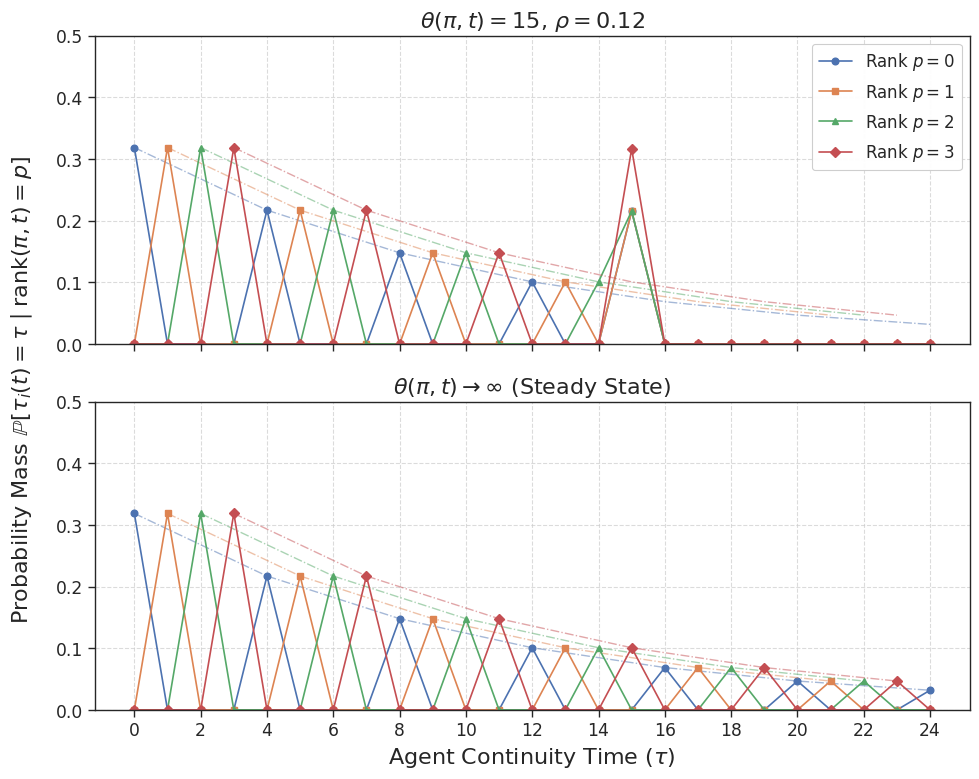

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

def calculate_continuity_dist(tau, p, P, rho, theta):
    """
    Calculates the continuity-time probability distribution:
    P[tau_i(t) = tau | rank(pi, t) = p]
    """
    probs = np.zeros_like(tau, dtype=float)

    # Case 2: Standard shifting behavior (tau < theta)
    condition2 = (tau < theta) & (tau % P == p)
    if np.any(condition2):
        exponent2 = np.floor((tau[condition2] - p) / P) * (P - 1)
        probs[condition2] = (1 - (1 - rho)**(P - 1)) * (1 - rho)**exponent2

    # Case 1: Spike at loss horizon (tau = theta)
    if not np.isinf(theta):
        condition1 = (tau == theta)
        if np.any(condition1):
             exponent1 = np.ceil((theta - p) / P) * (P - 1)
             probs[condition1] = (1 - rho)**exponent1

    return probs

def envelope_function(tau, p, P, rho):
    """Calculates the theoretical decay envelope for visualization."""
    return (1 - (1-rho)**(P-1)) * (1-rho)**((tau - p)/P * (P-1))

def plot_figure_1():
    """
    Generates Figure 1: Probability distribution of agent continuity times.
    """

    # --- Model Parameters ---
    P = 4               # Total Paths
    rho = 0.12          # Responsiveness (Migration Probability)
    tau_range = np.arange(0, 25)

    # --- Plot Setup ---
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
    colors = sns.color_palette("deep", P)
    markers = ['o', 's', '^', 'D']

    # --- Panel 1: Finite Horizon (Recent Loss) ---
    ax1 = axes[0]
    theta_finite = 15
    ax1.set_title(fr'$\theta(\pi, t) = {theta_finite}$, $\rho = {rho}$', fontsize=16)

    for p_rank in range(P):
        probs = calculate_continuity_dist(tau_range, p_rank, P, rho, theta_finite)

        ax1.plot(tau_range, probs, marker=markers[p_rank], color=colors[p_rank],
                 linestyle='-', label=f'Rank $p={p_rank}$')

        # Theoretical envelope
        envelope_tau = np.arange(p_rank, tau_range.max() + 1, P)
        envelope_y = envelope_function(envelope_tau, p_rank, P, rho)
        ax1.plot(envelope_tau, envelope_y, linestyle='-.', color=colors[p_rank], alpha=0.5, linewidth=1)

    # --- Panel 2: Infinite Horizon (Steady State) ---
    ax2 = axes[1]
    theta_inf = float('inf')
    ax2.set_title(r'$\theta(\pi, t) \rightarrow \infty$ (Steady State)', fontsize=16)

    for p_rank in range(P):
        probs = calculate_continuity_dist(tau_range, p_rank, P, rho, theta_inf)
        ax2.plot(tau_range, probs, marker=markers[p_rank], color=colors[p_rank],
                 linestyle='-')

        # Theoretical envelope
        envelope_tau = np.arange(p_rank, tau_range.max() + 1, P)
        envelope_y = envelope_function(envelope_tau, p_rank, P, rho)
        ax2.plot(envelope_tau, envelope_y, linestyle='-.', color=colors[p_rank], alpha=0.5, linewidth=1)

    # --- Formatting & Labels ---
    fig.supylabel(r'Probability Mass $\mathbb{P}[\tau_i(t) = \tau \mid \mathrm{rank}(\pi,t) = p]$', fontsize=16)

    ax1.set_ylim(0, 0.5)
    ax2.set_ylim(0, 0.5)

    ax2.set_xlabel(r'Agent Continuity Time ($\tau$)', fontsize=16)
    ax2.set_xticks(np.arange(0, 25, 2))

    ax1.grid(True, which='both', linestyle='--', alpha=0.7)
    ax2.grid(True, which='both', linestyle='--', alpha=0.7)

    ax1.legend(loc='upper right', fontsize=12, framealpha=0.95)

    plt.tight_layout()

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig01_continuity_dist')

    # Added bbox_inches='tight'
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.savefig(f'{base_filename}.pdf', bbox_inches='tight', pad_inches=0.05)

    print(f"Figure 1 saved to: {base_filename}.pdf")
    plt.show()

if __name__ == "__main__":
    plot_figure_1()

**Figure 2: Logical Consistency of the P-step Oscillation**

Calculating consistency regions... (this may take a moment)
Figure 2 saved to: figures/fig02_pstep_consistency_plot.pdf


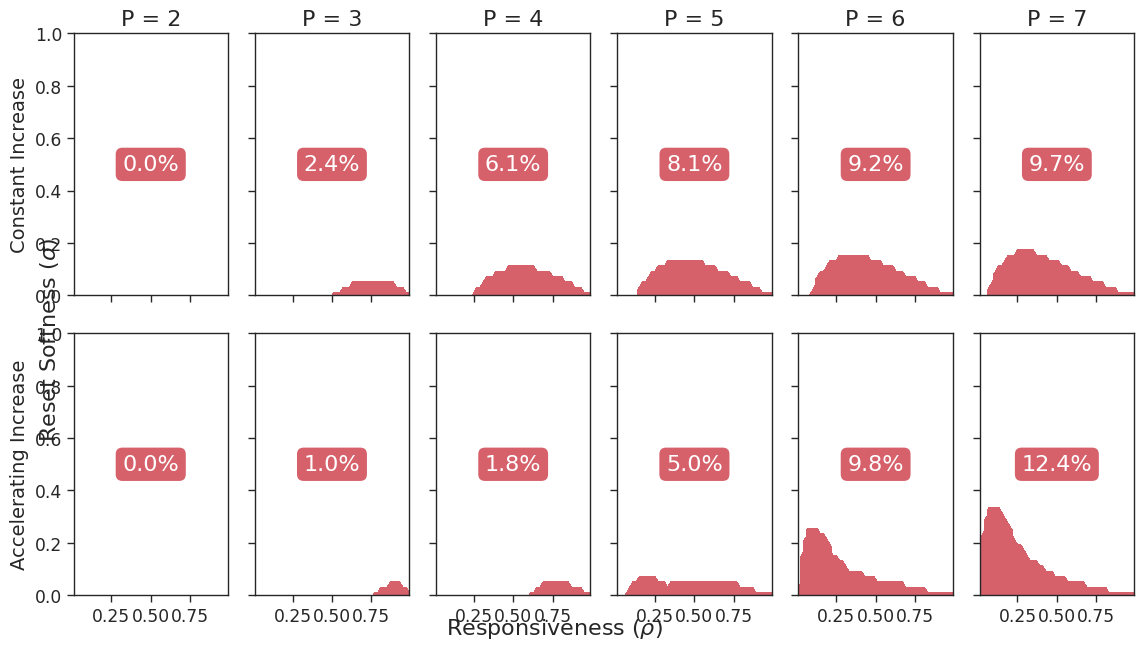

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

# Suppress runtime warnings that can occur during numerical simulation (e.g., division by zero)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Helper Functions ---

def alpha_S_func(tau):
    """
    Accelerating additive increase (linear).
    alpha(tau) = 2*tau if tau < 5 else 1
    """
    return np.where(tau < 5, 2 * tau, 1)

def alpha_1_func(tau):
    """Constant additive increase. alpha(tau) = 1"""
    return 1

def calculate_alpha_hat_p(alpha_func, rho, P, num_terms=30):
    """Calculates the expected additive increase per path rank."""
    alpha_hat = np.zeros(P)
    term_const = 1 - (1 - rho)**(P - 1)

    # Fallback for rho=0 case
    if term_const == 0: return np.ones(P) * alpha_func(0)

    for p_rank in range(P):
        series_sum = sum(
            (1 - rho)**(k * (P - 1)) * alpha_func(P * k + p_rank)
            for k in range(num_terms)
        )
        alpha_hat[p_rank] = term_const * series_sum
    return alpha_hat

def calculate_f_hat_p_vector(rho, sigma, P, alpha_func, N=1):
    """
    Calculates the equilibrium load vector f^(p) to check for consistency.
    Derived from the fixed-point equations.
    """
    if rho == 0 or rho == 1: return np.zeros(P) # Avoid edge case instability

    a_hat_p = np.array([((1 - rho)**p * rho * N) / (1 - (1 - rho)**P) for p in range(P)])
    alpha_hat_p = calculate_alpha_hat_p(alpha_func, rho, P)

    z_rho_p = (1 - (1 - rho)**(P - 1)) / (rho * (1 - rho)**(P - 1))
    q_factor = 1 + rho * sigma * z_rho_p

    common_ratio = q_factor * (1 - rho)**(P - 1)
    denominator = 1 - common_ratio

    if abs(denominator) < 1e-9: # Divergent case
        return np.full(P, np.inf)

    f_hat_p = np.zeros(P)
    for p_rank in range(P):
        t1 = sum((1-rho)**(p_rank-p_prime) * alpha_hat_p[p_prime] * a_hat_p[p_prime] for p_prime in range(p_rank))
        t2 = (1-rho)**p_rank * alpha_hat_p[P-1] * a_hat_p[P-1]
        t3 = q_factor * sum((1-rho)**(P-1+p_rank-p_prime) * alpha_hat_p[p_prime] * a_hat_p[p_prime] for p_prime in range(p_rank, P-1))
        f_hat_p[p_rank] = (t1 + t2 + t3) / denominator
    return f_hat_p

def is_inconsistent(rho, sigma, P, alpha_func):
    """
    Checks if a parameter set (rho, sigma) violates the P-step oscillation assumption.
    Returns True if the rank ordering is violated (i.e., Load[p] < Load[p+1]).
    """
    f_hat_p = calculate_f_hat_p_vector(rho, sigma, P, alpha_func)

    # Divergence is not considered an inconsistency in rank ordering
    if np.any(np.isinf(f_hat_p)): return False

    for p in range(P - 1):
        if f_hat_p[p] < f_hat_p[p+1]:
            return True # Found an inconsistency
    return False

def plot_figure_2():
    """
    Generates Figure 2: Logical consistency of the P-step oscillation.
    """

    # --- Configuration ---
    alpha_configs = {
        'alpha_1': {
            'func': alpha_1_func,
            'title': r'Constant Increase'
        },
        'alpha_S': {
            'func': alpha_S_func,
            'title': r'Accelerating Increase'
        }
    }
    P_vals = [2, 3, 4, 5, 6, 7]

    # Grid resolution for heatmap
    grid_res = 50
    rho_vals = np.linspace(0.01, 0.99, grid_res)
    sigma_vals = np.linspace(0.0, 1.0, grid_res)
    Rho, Sigma = np.meshgrid(rho_vals, sigma_vals)

    print("Calculating consistency regions... (this may take a moment)")

    fig, axes = plt.subplots(2, 6, figsize=(12, 7), sharex=True, sharey=True)

    # --- Global Labels ---
    fig.supxlabel(r"Responsiveness ($\rho$)", fontsize=16, y=0.07)
    fig.supylabel(r"Reset Softness ($\sigma$)", fontsize=16, x=0.07)

    # --- Main Plotting Loop ---
    for row, config in enumerate(alpha_configs.values()):
        alpha_func = config['func']
        row_title = config['title']

        for col, P in enumerate(P_vals):
            ax = axes[row, col]

            # Compute inconsistency boolean map
            Z = np.zeros_like(Rho, dtype=bool)
            for i in range(grid_res):
                for j in range(grid_res):
                    rho_pt, sigma_pt = Rho[i, j], Sigma[i, j]
                    Z[i, j] = is_inconsistent(rho_pt, sigma_pt, P, alpha_func)

            # Plot shaded region (Red = Inconsistent)
            ax.contourf(Rho, Sigma, Z, levels=[0.5, 1.5], colors=['#d6616b'])

            # Annotate percentage of space that is inconsistent
            percentage = np.mean(Z) * 100
            ax.text(0.5, 0.5, f'{percentage:.1f}%', ha='center', va='center',
                    transform=ax.transAxes, fontsize=16, color='white',
                    bbox=dict(boxstyle='round,pad=0.3', fc='#d6616b', ec='none'))

            # Column Titles (Number of Paths)
            if row == 0:
                ax.set_title(f"P = {P}", fontsize=16)

            # Row Titles (Growth Function)
            if col == 0:
                ax.text(-0.35, 0.5, row_title,
                        ha='center', va='center',
                        rotation=90,
                        transform=ax.transAxes,
                        fontsize=14)

    plt.tight_layout()

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig02_pstep_consistency_plot')

    plt.savefig(f'{base_filename}.png', dpi=300)
    plt.savefig(f'{base_filename}.pdf', dpi=300)
    print(f"Figure 2 saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_2()

**Figure 3: Visual Proof of Convergence to the Lossless Dynamic Equilibrium**

--- Generating Figure 3-a (Agent Count) ---
  Equilibrium Levels: a^(0)=369.00, a^(1)=332.10, a^(2)=298.89
  Saved figures/fig03-a_agent_convergence.pdf
--- Generating Figure 3-b (Path Load) ---
  Path Load Equilibrium: [5191.26 4480.87 3846.99]
  Saved figures/fig03-b_load_convergence.pdf

All Figure 3 plots generated.


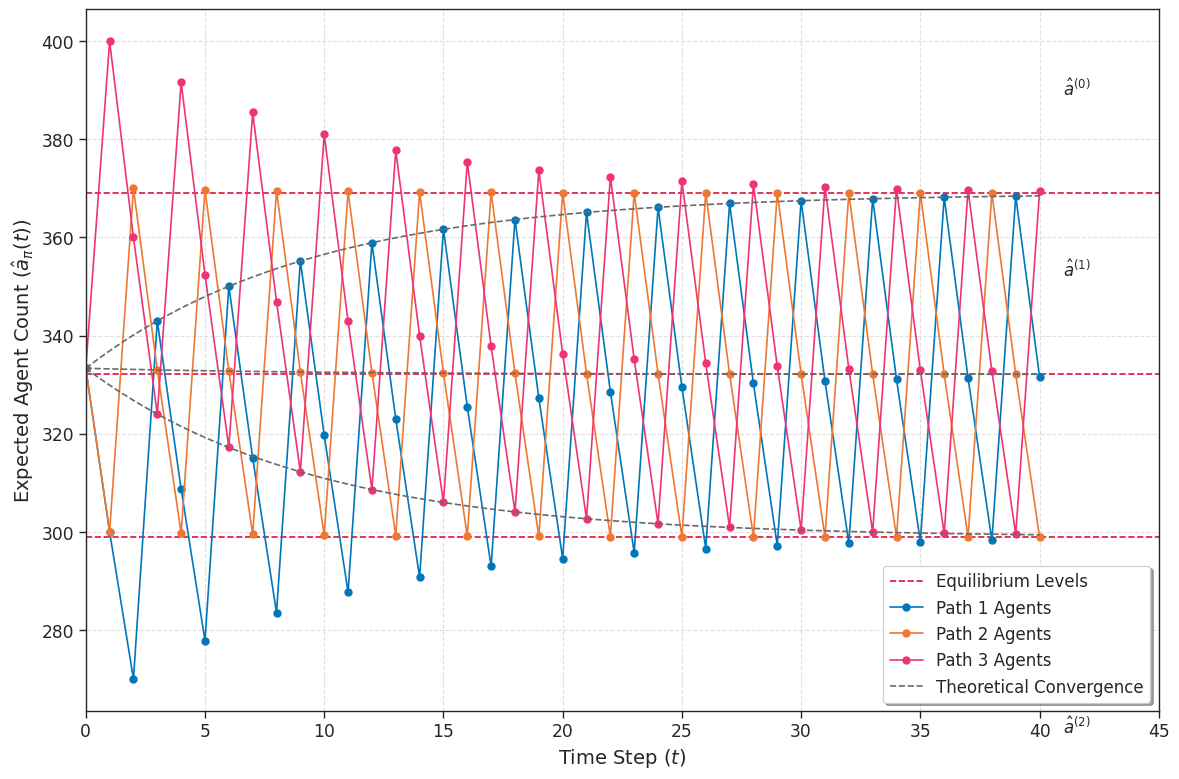

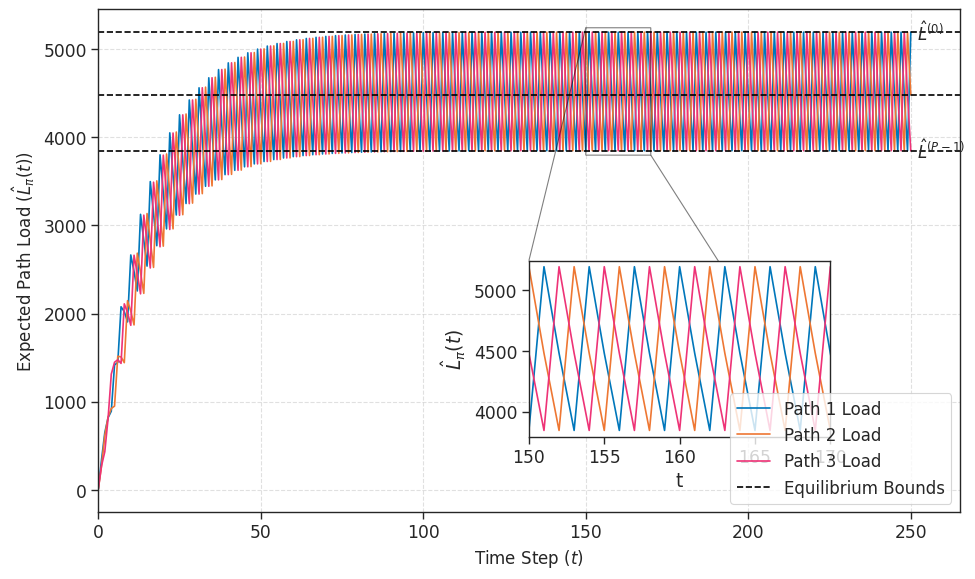

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

def plot_figure_3a():
    """
    Generates Figure 3-a: Convergence of Expected Agent Count.
    Simulation with rho=0.1 showing exponential convergence to equilibrium.
    """
    print("--- Generating Figure 3-a (Agent Count) ---")

    # --- Parameters ---
    P = 3           # Number of paths
    rho = 0.1       # Responsiveness (rho)
    N = 1000        # Total number of agents
    T_MAX = 41      # Simulation time steps

    # --- 1. Calculate Equilibrium Agent Levels (Eq. 6) ---
    # a_hat^(p) formula
    equilibrium_levels = np.array([
        ((1 - rho)**p * rho * N) / (1 - (1 - rho)**P) for p in range(P)
    ])
    a_eq_0, a_eq_1, a_eq_2 = equilibrium_levels

    print(f"  Equilibrium Levels: a^(0)={a_eq_0:.2f}, a^(1)={a_eq_1:.2f}, a^(2)={a_eq_2:.2f}")

    # --- 2. Simulate Agent Dynamics (Eq. 3a) ---
    agents_history = np.zeros((T_MAX, P))
    agents_history[0, :] = N / P

    for t in range(T_MAX - 1):
        current_agents = agents_history[t, :]
        next_agents = np.zeros(P)
        # Determine which path is the target (cyclic behavior in this deterministic model)
        pi_min_idx = (P - 1 - t) % P

        for i in range(P):
            if i == pi_min_idx:
                next_agents[i] = current_agents[i] + rho * (N - current_agents[i])
            else:
                next_agents[i] = (1 - rho) * current_agents[i]
        agents_history[t+1, :] = next_agents

    # --- 3. Calculate Trajectory Functions (Convergence check) ---
    t_values = np.linspace(0, T_MAX - 1, 200)
    a_start = N / P
    trajectory_0 = (a_start - a_eq_0) * (1 - rho)**t_values + a_eq_0
    trajectory_1 = (a_start - a_eq_1) * (1 - rho)**t_values + a_eq_1
    trajectory_2 = (a_start - a_eq_2) * (1 - rho)**t_values + a_eq_2

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(12, 8))
    time_steps = np.arange(T_MAX)

    path_colors = ['#0077BB', '#EE7733', '#EE3377']
    equilibrium_color = 'crimson'
    trajectory_color = 'dimgray'

    # Plot Equilibrium Levels
    ax.axhline(y=a_eq_0, color=equilibrium_color, linestyle='--', label='Equilibrium Levels')
    ax.axhline(y=a_eq_1, color=equilibrium_color, linestyle='--', label='_nolegend_')
    ax.axhline(y=a_eq_2, color=equilibrium_color, linestyle='--', label='_nolegend_')

    # Plot Simulation Dynamics
    ax.plot(time_steps, agents_history[:, 0], '-o', color=path_colors[0], markersize=5, label='Path 1 Agents')
    ax.plot(time_steps, agents_history[:, 1], '-o', color=path_colors[1], markersize=5, label='Path 2 Agents')
    ax.plot(time_steps, agents_history[:, 2], '-o', color=path_colors[2], markersize=5, label='Path 3 Agents')

    # Plot Theoretical Trajectories
    ax.plot(t_values, trajectory_0, '--', color=trajectory_color, label='Theoretical Convergence')
    ax.plot(t_values, trajectory_1, '--', color=trajectory_color, label='_nolegend_')
    ax.plot(t_values, trajectory_2, '--', color=trajectory_color, label='_nolegend_')

    # Annotations
    ax.annotate(r'$\hat{a}^{(0)}$', xy=(38, a_eq_0), xytext=(41, a_eq_0 + 20), fontsize=12)
    ax.annotate(r'$\hat{a}^{(1)}$', xy=(38, a_eq_1), xytext=(41, a_eq_1 + 20), fontsize=12)
    ax.annotate(r'$\hat{a}^{(2)}$', xy=(38, a_eq_2), xytext=(41, a_eq_2 - 40), fontsize=12)

    # Formatting
    ax.set_xlabel('Time Step ($t$)', fontsize=14)
    ax.set_ylabel(r'Expected Agent Count ($\hat{a}_{\pi}(t)$)', fontsize=14)
    ax.set_xlim(0, 45) # Extended slightly for annotations
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.legend(loc='best', fontsize=12, frameon=True, shadow=True)

    # Save
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig03-a_agent_convergence')
    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300)
    plt.savefig(f'{base_filename}.pdf', dpi=300)
    print(f"  Saved {base_filename}.pdf")

def plot_figure_3b():
    """
    Generates Figure 3-b: Convergence of Expected Path Load.
    Simulation with rho=0.2 showing load oscillation within equilibrium bounds.
    """
    print("--- Generating Figure 3-b (Path Load) ---")

    # --- 1. Parameters ---
    P = 3           # Number of Paths
    N = 1000        # Total Agents
    rho = 0.2       # Responsiveness (rho)
    sigma = 0.5     # Reset Softness (sigma)
    alpha = 1.0     # Average Additive Increase
    T_max = 251     # Simulation duration

    # --- 2. Analytical Equilibrium (Eq. 7 & 8) ---
    ranks = np.arange(P)
    a_eq = ((1 - rho)**ranks * rho * N) / (1 - (1 - rho)**P)

    # Extrapolation factor z(.)
    z_eq = np.zeros(P)
    for p in range(P):
        if a_eq[p] > 0:
            z_eq[p] = (N - a_eq[p]) / a_eq[p]

    # Solve linear system for Load Equilibrium
    # M * L_eq = V
    M_sys = np.array([
        [1, 0, -(1 + rho * sigma * z_eq[2])],
        [-(1 - rho), 1, 0],
        [0, -(1 - rho), 1]
    ])
    V_sys = np.array([
        alpha * a_eq[2],
        (1 - rho) * alpha * a_eq[0],
        (1 - rho) * alpha * a_eq[1]
    ])
    L_eq = np.linalg.solve(M_sys, V_sys)

    print(f"  Path Load Equilibrium: {np.round(L_eq, 2)}")

    # --- 3. Simulation ---
    t_steps = np.arange(T_max)
    a_hat = np.zeros((P, T_max))
    L_hat = np.zeros((P, T_max))

    # Init
    a_hat[:, 0] = N / P
    L_hat[:, 0] = 10.0

    for t in range(T_max - 1):
        # Greedy selection: find path with min load
        pi_min_idx = np.argmin(L_hat[:, t])

        for pi in range(P):
            current_a = a_hat[pi, t]
            current_L = L_hat[pi, t]

            # Update Agent Dynamics
            if pi == pi_min_idx:
                a_hat[pi, t+1] = (1 - rho) * current_a + rho * N
            else:
                a_hat[pi, t+1] = (1 - rho) * current_a

            # Update Path Load Dynamics (Eq 3b)
            if pi == pi_min_idx:
                z_t = (N - current_a) / current_a if current_a > 0 else 0
                L_hat[pi, t+1] = (1 + rho * sigma * z_t) * current_L + alpha * current_a
            else:
                L_hat[pi, t+1] = (1 - rho) * (current_L + alpha * current_a)

    # --- 4. Plotting ---
    path_colors = ['#0077BB', '#EE7733', '#EE3377']

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Load
    for pi in range(P):
        ax.plot(t_steps, L_hat[pi, :], color=path_colors[pi], label=f'Path {pi+1} Load')

    # Plot Equilibrium Bounds
    for p in range(P):
        ax.axhline(y=L_eq[p], color='black', linestyle='--',
                   label='Equilibrium Bounds' if p == 0 else '_nolegend_')

    # Annotations
    ax.annotate(r'$\hat{L}^{(0)}$', xy=(240, L_eq[0]), xytext=(252, L_eq[0]),
                 fontsize=12, verticalalignment='center')
    ax.annotate(r'$\hat{L}^{(P-1)}$', xy=(240, L_eq[P-1]), xytext=(252, L_eq[P-1]),
                 fontsize=12, verticalalignment='center')

    # Formatting
    ax.set_xlabel('Time Step ($t$)', fontsize=12)
    ax.set_ylabel(r'Expected Path Load ($\hat{L}_{\pi}(t)$)', fontsize=12)
    ax.set_xlim(0, 265)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='lower right', fontsize=12)

    # --- Inset: Zoom on Oscillation ---
    ax_inset = ax.inset_axes([0.5, 0.15, 0.35, 0.35])
    for pi in range(P):
        ax_inset.plot(t_steps, L_hat[pi, :], color=path_colors[pi])

    # Inset limits
    inset_xlim = (150, 170)
    inset_mask = (t_steps >= inset_xlim[0]) & (t_steps <= inset_xlim[1])
    inset_ymin = np.min(L_hat[:, inset_mask]) - 50
    inset_ymax = np.max(L_hat[:, inset_mask]) + 50

    ax_inset.set_xlim(inset_xlim)
    ax_inset.set_ylim(inset_ymin, inset_ymax)
    ax_inset.set_xlabel('t')
    ax_inset.set_ylabel(r'$\hat{L}_{\pi}(t)$')
    ax.indicate_inset_zoom(ax_inset, edgecolor="black")

    # Save
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig03-b_load_convergence')

    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300)
    plt.savefig(f'{base_filename}.pdf', dpi=300)
    print(f"  Saved {base_filename}.pdf")

def plot_figure_3_all():
    """Run both sub-figures for Figure 3."""
    plot_figure_3a()
    plot_figure_3b()
    print("\nAll Figure 3 plots generated.")
    plt.show()

if __name__ == "__main__":
    plot_figure_3_all()

**Figure 4: Structural Patterns of Lossy Dynamic Equilibria**

--- Generating Figure 4(a) (Type-1 Lossy, High-rho) ---
  Saved figures/fig04a_lossy_high_rho.pdf
--- Generating Figure 4(b) (Type-2 Lossy, Low-rho) ---
  Saved figures/fig04b_lossy_low_rho.pdf

All Figure 4 plots generated.


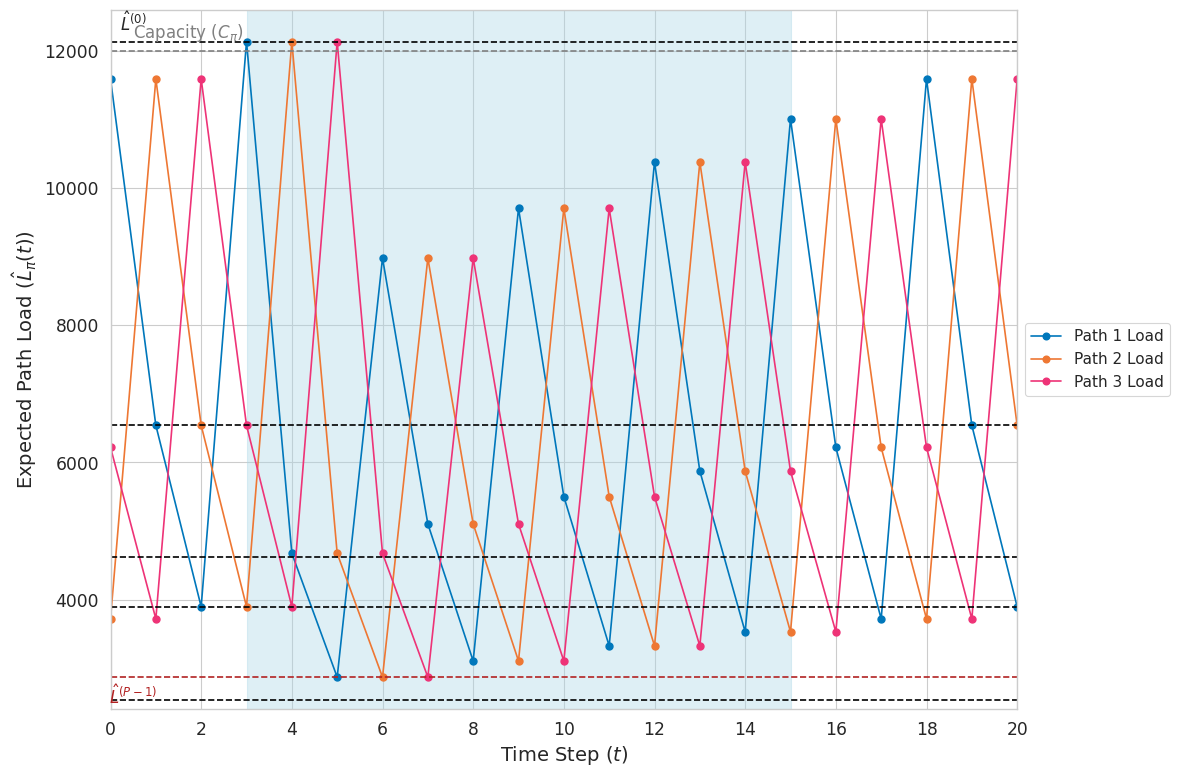

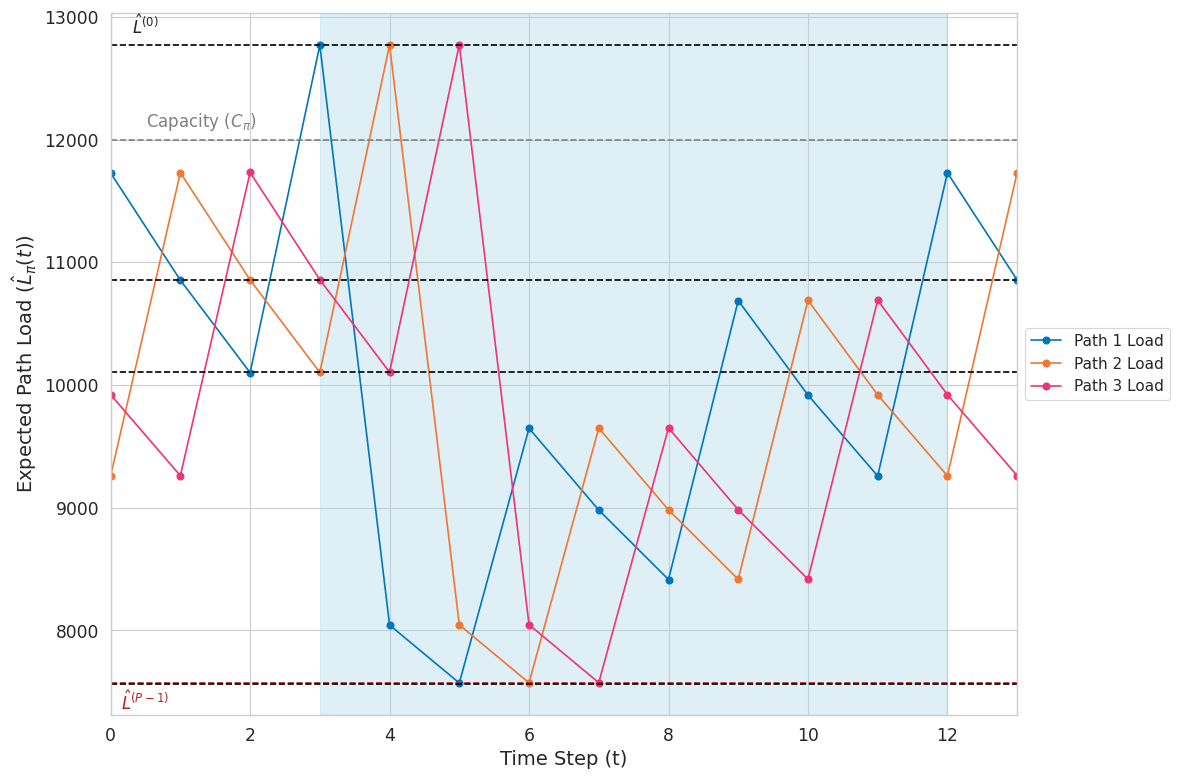

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.signal import find_peaks
from matplotlib.ticker import MultipleLocator

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

def plot_figure_4a():
    """
    Generates Figure 4(a): Type-1 Lossy Equilibrium (High Responsiveness).
    The loss event is absorbed into the existing P-step cycle.
    """
    print("--- Generating Figure 4(a) (Type-1 Lossy, High-rho) ---")

    # --- Parameters ---
    P = 3           # Number of paths
    rho = 0.45      # Responsiveness (rho)
    sigma = 0.9     # Reset softness (sigma)
    N = 1000        # Total number of agents
    C_pi = 12000    # Path capacity
    gamma = 0.7     # Multiplicative decrease factor (gamma)

    # Simulation time
    BURN_IN_STEPS = 200
    PLOT_STEPS = 21
    T_MAX = BURN_IN_STEPS + PLOT_STEPS

    # --- 1. Pre-computation ---
    # Calculate standard equilibrium components
    a_hat_p = np.array([((1 - rho)**p * rho * N) / (1 - (1 - rho)**P) for p in range(P)])
    alpha_hat_p = np.ones(P)
    z_rho_p = (1 - (1 - rho)**(P - 1)) / (rho * (1 - rho)**(P - 1))
    q_factor = 1 + rho * sigma * z_rho_p

    # --- 2. Simulate Full Lossy Dynamics ---
    load_history = np.zeros((T_MAX, P))
    path_ranks = np.arange(P)

    for t in range(T_MAX - 1):
        current_load = load_history[t, :]
        next_load = np.zeros(P)

        for i in range(P):
            rank = path_ranks[i]
            is_lossy = current_load[i] > C_pi

            if rank == P - 1: # Path is pi_min(t) (Target)
                if is_lossy:
                    next_load[i] = (gamma + rho * sigma * z_rho_p) * current_load[i]
                else:
                    next_load[i] = q_factor * current_load[i] + alpha_hat_p[P-1] * a_hat_p[P-1]
            else: # Path is not pi_min(t)
                if is_lossy:
                    next_load[i] = gamma * (1 - rho) * current_load[i]
                else:
                    next_load[i] = (1 - rho) * (current_load[i] + alpha_hat_p[rank] * a_hat_p[rank])

        load_history[t+1, :] = next_load
        # Standard P-step rank rotation
        path_ranks = (path_ranks - 1 + P) % P

    # --- 3. Data Extraction for Plotting ---
    plot_data = load_history[BURN_IN_STEPS:, :]
    time_axis = np.arange(PLOT_STEPS)

    # Identify equilibrium features
    L_star_plus = np.max(plot_data)
    L_star_minus = np.min(plot_data)

    # Robust peak finding to determine period L
    peaks, _ = find_peaks(plot_data[:, 0], height=L_star_plus * 0.9, distance=P)

    if len(peaks) > 1:
        L = peaks[1] - peaks[0]
        peak_time = peaks[0]
    else:
        L = P
        peak_time = 0

    f_hat_1_star = plot_data[peak_time, (peak_time + 1) % P]
    f_hat_2_star = plot_data[peak_time, (peak_time + 2) % P]

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(12, 8))
    path_colors = ['#0077BB', '#EE7733', '#EE3377']

    # Highlight one period
    ax.axvspan(peak_time, peak_time + L, color='lightblue', alpha=0.4)

    for i in range(P):
        ax.plot(time_axis, plot_data[:, i], '-o', color=path_colors[i], markersize=5)

    # Reference Lines
    ax.axhline(L_star_plus, ls='--', color='black')
    ax.axhline(C_pi, ls='--', color='gray')
    ax.axhline(f_hat_1_star, ls='--', color='black')
    ax.axhline(gamma * (1 - rho) * C_pi, ls='--', color='black')
    ax.axhline(f_hat_2_star, ls='--', color='black')
    ax.axhline(L_star_minus, ls='--', color='firebrick')
    ax.axhline(gamma * (1 - rho)**2 * C_pi, ls='--', color='black')

    # Annotations
    annot_x = 0.5
    ax.annotate(r"$\hat{L}^{(0)}$", xy=(annot_x, L_star_plus), xytext=(0, 5),
                textcoords='offset points', ha='center', va='bottom', fontsize=12)
    ax.annotate(r"Capacity ($C_{\pi}$)", xy=(annot_x, C_pi), xytext=(0, 5),
                textcoords='offset points', ha='left', va='bottom', fontsize=12, color='gray')
    ax.annotate(r"$\hat{L}^{(P-1)}$", xy=(annot_x, L_star_minus), xytext=(0, -5),
                textcoords='offset points', ha='center', va='top', fontsize=12, color='firebrick')

    # Styling
    ax.set_xlabel('Time Step ($t$)', fontsize=14)
    ax.set_ylabel(r'Expected Path Load ($\hat{L}_{\pi}(t)$)', fontsize=14)
    ax.set_xlim(0, PLOT_STEPS - 1)
    ax.xaxis.set_major_locator(MultipleLocator(2))

    # Legend
    handles = [plt.Line2D([0], [0], color=c, marker='o') for c in path_colors[:P]]
    labels = [f'Path {i+1} Load' for i in range(P)]
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
    plt.tight_layout()

    # Save
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig04a_lossy_high_rho')
    plt.savefig(f'{base_filename}.png', dpi=300)
    plt.savefig(f'{base_filename}.pdf', dpi=300)
    print(f"  Saved {base_filename}.pdf")


def plot_figure_4b():
    """
    Generates Figure 4(b): Type-2 Lossy Equilibrium (Low Responsiveness).
    The severe multiplicative decrease disrupts the standard rank ordering.
    """
    print("--- Generating Figure 4(b) (Type-2 Lossy, Low-rho) ---")

    # --- Parameters ---
    P = 3           # Number of paths
    rho = 0.1       # Responsiveness (rho)
    sigma = 1.0     # Reset softness (sigma)
    N = 1000        # Total number of agents
    C_pi = 12000    # Path capacity
    gamma = 0.7     # Multiplicative decrease factor (gamma)

    # Simulation time
    BURN_IN_STEPS = 200
    PLOT_STEPS = 14
    T_MAX = BURN_IN_STEPS + PLOT_STEPS

    # --- 1. Pre-computation ---
    a_hat_p = np.array([((1 - rho)**p * rho * N) / (1 - (1 - rho)**P) for p in range(P)])
    alpha_hat_p = np.ones(P)
    z_rho_p = (1 - (1 - rho)**(P - 1)) / (rho * (1 - rho)**(P - 1))

    # --- 2. Simulate Dynamics with Dynamic Ranks ---
    load_history = np.zeros((T_MAX, P))
    path_ranks = np.arange(P)

    for t in range(T_MAX - 1):
        current_load = load_history[t, :]
        next_load = np.zeros(P)

        # --- Apply load dynamics based on current ranks ---
        for i in range(P):
            rank = path_ranks[i]
            is_lossy = current_load[i] > C_pi
            is_pi_min = (rank == P - 1)

            if is_pi_min:
                q_factor = 1 + rho * sigma * z_rho_p
                if is_lossy:
                    next_load[i] = (gamma + rho * sigma * z_rho_p) * current_load[i]
                else:
                    next_load[i] = q_factor * current_load[i] + alpha_hat_p[P-1] * a_hat_p[P-1]
            else: # Path is not pi_min(t)
                if is_lossy:
                    next_load[i] = gamma * (1 - rho) * current_load[i]
                else:
                    next_load[i] = (1 - rho) * (current_load[i] + alpha_hat_p[rank] * a_hat_p[rank])

        load_history[t+1, :] = next_load

        # --- Update ranks for the next time step ---
        pi_rank_0_idx = np.where(path_ranks == 0)[0][0]
        loss_occurred = current_load[pi_rank_0_idx] > C_pi

        if loss_occurred:
            # Type-2 rule: Overloaded path drops immediately to lowest rank (P-1)
            next_ranks = np.zeros_like(path_ranks)
            next_ranks[pi_rank_0_idx] = P - 1
            for i in range(P):
                if i != pi_rank_0_idx:
                    next_ranks[i] = path_ranks[i] - 1
            path_ranks = next_ranks
        else:
            # Normal P-step oscillation
            path_ranks = (path_ranks - 1 + P) % P

    # --- 3. Data Extraction ---
    plot_data = load_history[BURN_IN_STEPS:, :]
    time_axis = np.arange(PLOT_STEPS)

    L_star_plus = np.max(plot_data)
    L_star_minus = np.min(plot_data)

    peaks, _ = find_peaks(plot_data[:, 0], height=L_star_plus * 0.9, distance=P)

    if len(peaks) > 1:
        L = peaks[1] - peaks[0]
        peak_time = peaks[0]
    else:
        L = P
        peak_time = 0

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(12, 8))
    path_colors = ['#0077BB', '#EE7733', '#EE3377']

    # Highlight one period
    ax.axvspan(peak_time, peak_time + L, color='lightblue', alpha=0.4)

    for i in range(P):
        ax.plot(time_axis, plot_data[:, i], '-o', color=path_colors[i])

    # Reference Lines
    ax.axhline(L_star_plus, ls='--', color='black')
    ax.axhline(C_pi, ls='--', color='gray')
    ax.axhline(L_star_minus, ls='--', color='firebrick')
    ax.axhline(gamma * (1 - rho) * C_pi, ls='--', color='black')
    # Contextual intermediate lines
    ax.axhline(plot_data[peak_time, (peak_time + 1) % P], ls='--', color='black')
    ax.axhline(plot_data[peak_time, (peak_time + 2) % P], ls='--', color='black')

    # Annotations
    annot_x = 0.5
    ax.annotate(r"$\hat{L}^{(0)}$", xy=(annot_x, L_star_plus), xytext=(0, 5),
                textcoords='offset points', ha='center', va='bottom', fontsize=12)
    ax.annotate(r"Capacity ($C_{\pi}$)", xy=(annot_x, C_pi), xytext=(0, 5),
                textcoords='offset points', ha='left', va='bottom', fontsize=12, color='gray')
    ax.annotate(r"$\hat{L}^{(P-1)}$", xy=(annot_x, L_star_minus), xytext=(0, -5),
                textcoords='offset points', ha='center', va='top', fontsize=12, color='firebrick')

    # Styling
    ax.set_xlabel('Time Step (t)', fontsize=14)
    ax.set_ylabel(r'Expected Path Load ($\hat{L}_{\pi}(t)$)', fontsize=14)
    ax.set_xlim(0, PLOT_STEPS - 1)
    ax.xaxis.set_major_locator(MultipleLocator(2))

    # Legend
    handles = [plt.Line2D([0], [0], color=c, marker='o') for c in path_colors]
    labels = [f'Path {i+1} Load' for i in range(P)]
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
    plt.tight_layout()

    # Save
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig04b_lossy_low_rho')
    plt.savefig(f'{base_filename}.png', dpi=300)
    plt.savefig(f'{base_filename}.pdf', dpi=300)
    print(f"  Saved {base_filename}.pdf")

def plot_figure_4_all():
    """Generate both lossy equilibrium figures."""
    plot_figure_4a()
    plot_figure_4b()
    print("\nAll Figure 4 plots generated.")
    plt.show()

if __name__ == "__main__":
    plot_figure_4_all()

**Figure 5: Sensitivity to Path Diversity**

--- Generating Figure 5 (Path Diversity) ---
Simulating 12 scenarios...
Simulations complete.
Figure 5 saved to: figures/fig05_path_diversity.pdf


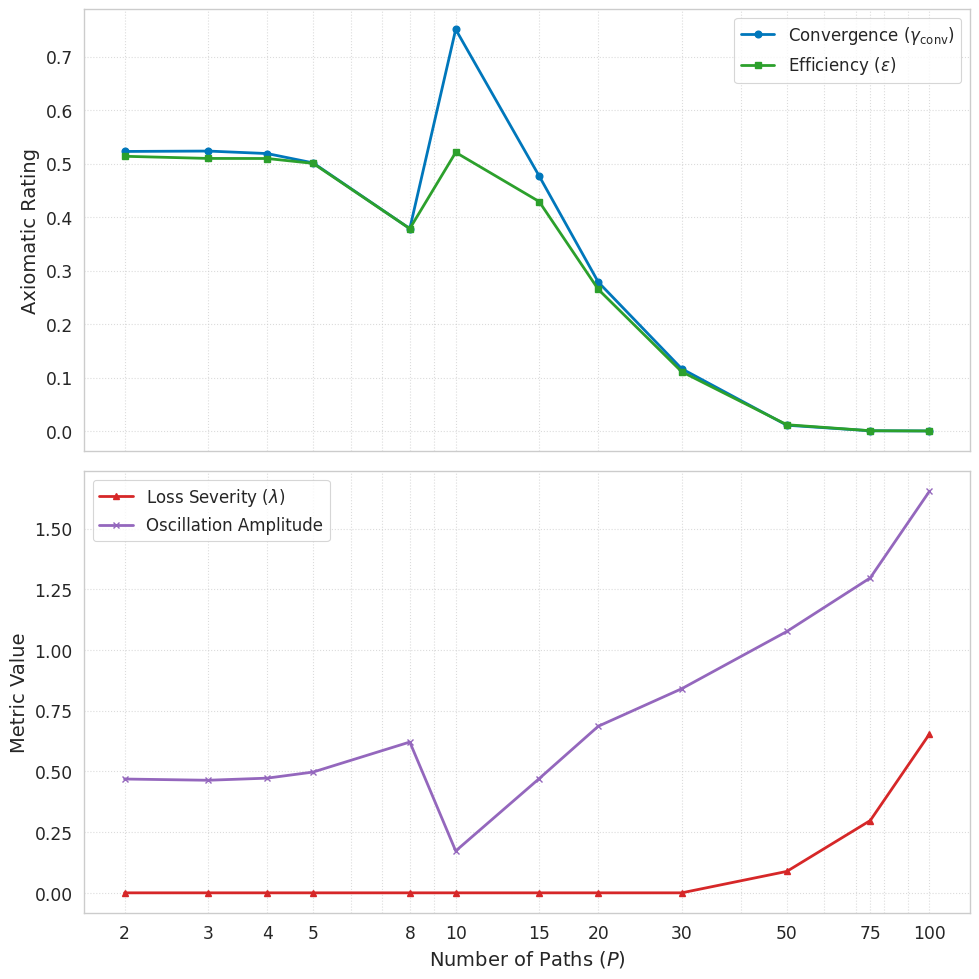

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

def simulate_path_diversity(P, N, rho, sigma, gamma, C_total, alpha, T_max, T_burn):
    """
    Simulates the network dynamics for a specific path count P to measure stability metrics.
    """
    C_per_path = C_total / P

    # Initialization (Start slightly perturbed to avoid perfect symmetry lock)
    a = np.ones(P) * (N / P)
    L = np.ones(P) * (C_per_path * 0.5)
    L[0] *= 1.01 # Small perturbation

    L_history = []

    for t in range(T_max):
        # 1. Identify path statuses (Greedy selection)
        idx_min = np.argmin(L)
        is_min = np.zeros(P, dtype=bool)
        is_min[idx_min] = True
        is_others = ~is_min

        # 2. Calculate Flows (based on state at t)
        flow_agents_out = a[is_others] * rho
        flow_load_out = L[is_others] * rho

        # 3. Update State (to t+1)
        a_next = a.copy()
        L_next = L.copy()

        # Agent Migration
        a_next[is_others] -= flow_agents_out
        a_next[idx_min] += np.sum(flow_agents_out)

        # Load Migration (Reset Softness applied to incoming load)
        L_next[is_others] -= flow_load_out
        L_next[idx_min] += np.sum(flow_load_out) * sigma

        # 4. Congestion Control Dynamics
        # Additive Increase
        L_next += alpha * a_next

        # Multiplicative Decrease
        overloaded = L_next > C_per_path
        L_next[overloaded] *= gamma

        # Update main variables
        a = a_next
        L = L_next

        if t >= T_burn:
            L_history.append(L.copy())

    # Analysis
    L_history = np.array(L_history)

    # Global metrics across the burn-in window
    flat_L = L_history.flatten()
    min_L = np.min(flat_L)
    max_L = np.max(flat_L)

    # Convergence: Ratio of min to max load (1.0 = perfect stability)
    gamma_conv = min_L / max_L if max_L > 0 else 0

    # Efficiency: Lowest utilization relative to capacity
    epsilon = min_L / C_per_path

    # Loss Severity: Max overshoot relative to capacity
    lambda_metric = max(0.0, (max_L - C_per_path) / C_per_path)

    # Oscillation Amplitude
    amplitude = (max_L - min_L) / C_per_path

    return epsilon, gamma_conv, lambda_metric, amplitude

def plot_figure_5():
    """
    Generates Figure 5: Stability Metrics vs. Path Diversity (P).
    """
    print("--- Generating Figure 5 (Path Diversity) ---")

    # Parameters
    Ps = np.array([2, 3, 4, 5, 8, 10, 15, 20, 30, 50, 75, 100])
    N = 5000.0          # Total Agents
    rho = 0.15          # Responsiveness (rho)
    sigma = 0.5         # Reset softness (sigma)
    gamma = 0.5         # Multiplicative decrease (gamma)
    C_total = 50000.0   # Total network capacity
    alpha = 1.0         # Additive increase
    T_max = 3000
    T_burn = 1500

    print(f"Simulating {len(Ps)} scenarios...")
    results = []
    for p in Ps:
        # Cast p to int for simulation logic
        res = simulate_path_diversity(int(p), N, rho, sigma, gamma, C_total, alpha, T_max, T_burn)
        results.append(res)
    print("Simulations complete.")

    # Unpack results
    results = np.array(results)
    epsilon = results[:, 0]
    gamma_conv = results[:, 1]
    lambda_metric = results[:, 2]
    amplitude = results[:, 3]

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Colors consistent with previous figures
    color_conv = '#0077BB' # Blue
    color_eff = '#2CA02C'  # Green
    color_loss = '#D62728' # Red
    color_amp = '#9467BD'  # Purple

    # Panel 1: Stability & Efficiency (Higher is Better)
    ax1.plot(Ps, gamma_conv, marker='o', color=color_conv, label=r'Convergence ($\gamma_{\mathrm{conv}}$)', lw=2)
    ax1.plot(Ps, epsilon, marker='s', color=color_eff, label=r'Efficiency ($\epsilon$)', lw=2)

    ax1.set_ylabel('Axiomatic Rating', fontsize=14)
    ax1.grid(True, which="both", linestyle=':', alpha=0.7)
    ax1.legend(loc='best', fontsize=12)

    # Panel 2: Instability & Loss (Lower is Better)
    ax2.plot(Ps, lambda_metric, marker='^', color=color_loss, label=r'Loss Severity ($\lambda$)', lw=2)
    ax2.plot(Ps, amplitude, marker='x', color=color_amp, label='Oscillation Amplitude', lw=2)

    ax2.set_xlabel('Number of Paths ($P$)', fontsize=14)
    ax2.set_ylabel('Metric Value', fontsize=14)

    # Handle Log Scale and Ticks
    ax2.set_xscale('log')
    ax2.set_xticks(Ps)
    ax2.set_xticklabels(Ps.astype(int))

    ax2.grid(True, which="both", linestyle=':', alpha=0.7)
    ax2.legend(loc='best', fontsize=12)

    # --- File Saving ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig05_path_diversity')

    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight', pad_inches=0.05)
    print(f"Figure 5 saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_5()

**Figure 7: Computation of the Fairness Metric ($\eta$)**

--- Generating Figure 7 (Fairness/Variance) ---
  Simulating: $\rho=0.5, \sigma=0.5$...
  Simulating: $\rho=0.5, \sigma=0.3$...
  Simulating: $\rho=0.4, \sigma=0.5$...
Figure 7 saved to: figures/fig07_fairness_variance.pdf


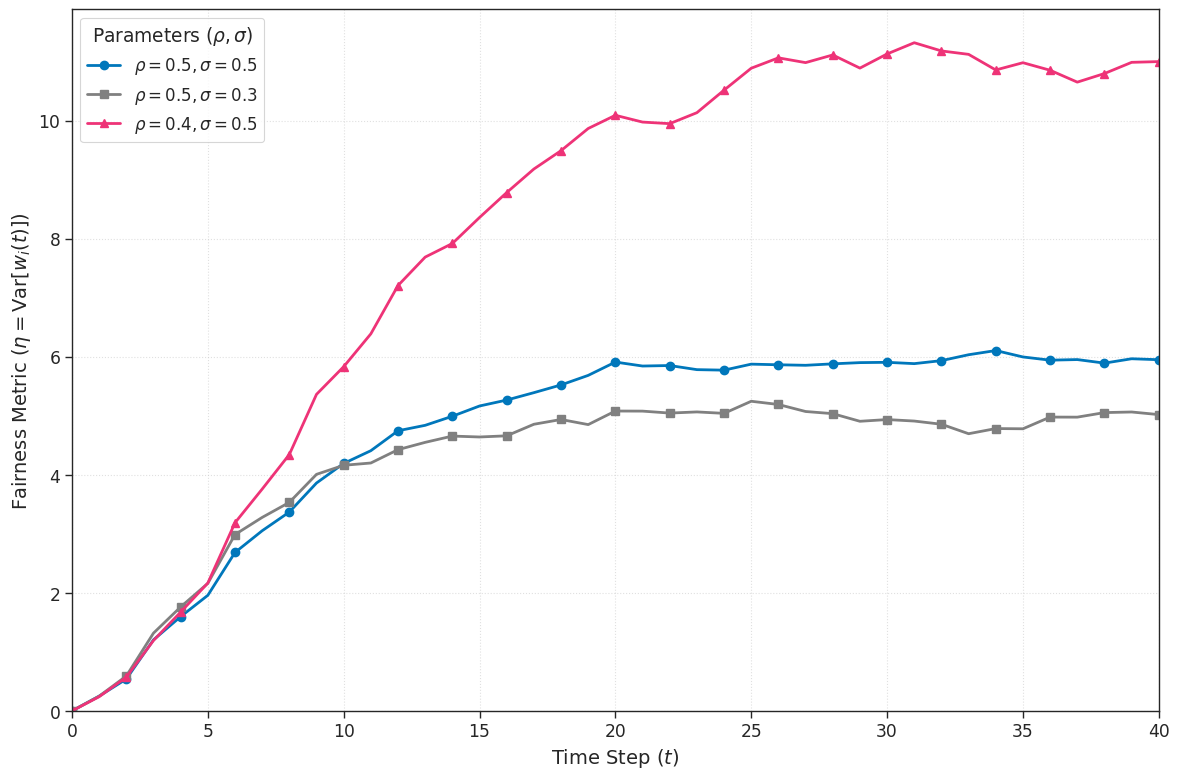

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

def simulate_variance(rho, sigma, P, alpha_func, N, T_max):
    """
    Simulates the Markov process for agent window evolution and computes
    the population-wide variance (Fairness metric eta).
    """
    # Initialize state: w (window size), tau (continuity time)
    w = np.zeros(N)
    tau = np.zeros(N, dtype=int)

    variance_history = np.zeros(T_max)

    for t in range(T_max):
        # 1. Record Fairness Metric (Variance of w)
        variance_history[t] = np.var(w)

        # 2. Determine Migration
        # Condition: migration only allowed if tau mod P != P-1
        can_migrate = (tau % P) != (P - 1)
        random_triggers = np.random.rand(N)

        will_migrate = can_migrate & (random_triggers < rho)
        will_stay = ~will_migrate

        # 3. Update State (Eq. 2 & Markov Process)
        next_w = np.zeros(N)
        next_tau = np.zeros(N, dtype=int)

        # Migrating agents: w -> w * sigma, tau -> 0
        next_w[will_migrate] = w[will_migrate] * sigma
        next_tau[will_migrate] = 0

        # Incumbent agents: w -> w + alpha(tau), tau -> tau + 1
        next_w[will_stay] = w[will_stay] + alpha_func(tau[will_stay])
        next_tau[will_stay] = tau[will_stay] + 1

        # Commit updates
        w = next_w
        tau = next_tau

    return variance_history

def plot_figure_7():
    """
    Generates Figure 7: Fairness Metric (Variance) vs. Time.
    Demonstrates how responsiveness (rho) and reset softness (sigma) impact equity.
    """
    print("--- Generating Figure 7 (Fairness/Variance) ---")

    # --- Parameters ---
    P = 3
    N = 10000       # Number of agents (samples)
    T_MAX = 41      # Simulation steps

    def alpha_func(tau): return 1.0

    # Scenarios from the paper
    scenarios = [
        {'rho': 0.5, 'sigma': 0.5, 'label': r'$\rho=0.5, \sigma=0.5$'},
        {'rho': 0.5, 'sigma': 0.3, 'label': r'$\rho=0.5, \sigma=0.3$'},
        {'rho': 0.4, 'sigma': 0.5, 'label': r'$\rho=0.4, \sigma=0.5$'},
    ]

    # --- Simulation ---
    results = []
    for params in scenarios:
        print(f"  Simulating: {params['label']}...")
        var_trace = simulate_variance(
            rho=params['rho'],
            sigma=params['sigma'],
            P=P,
            alpha_func=alpha_func,
            N=N,
            T_max=T_MAX
        )
        results.append(var_trace)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(12, 8))
    time_axis = np.arange(T_MAX)

    colors = ['#0077BB', 'gray', '#EE3377']
    markers = ['o', 's', '^']

    for i, (params, var_data) in enumerate(zip(scenarios, results)):
        ax.plot(time_axis, var_data, marker=markers[i], color=colors[i],
                label=params['label'], markersize=6, markevery=2, linewidth=2)

    # Labels using paper notation
    ax.set_xlabel('Time Step ($t$)', fontsize=14)
    ax.set_ylabel(r'Fairness Metric ($\eta = \mathrm{Var}[w_i(t)])$', fontsize=14)

    ax.set_xlim(0, 40)
    ax.set_ylim(bottom=0)

    ax.grid(linestyle=':', alpha=0.6)
    ax.legend(title=r"Parameters ($\rho, \sigma$)", loc='upper left', fontsize=12, frameon=True)

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig07_fairness_variance')

    # Use tight layout with crop
    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight', pad_inches=0.05)
    print(f"Figure 7 saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_7()

**Figure 8: Validation of the Expected Dynamics Model**

--- Generating Figure 8 (Model Validation) ---
Figure 8 saved to: figures/fig08_model_validation.pdf


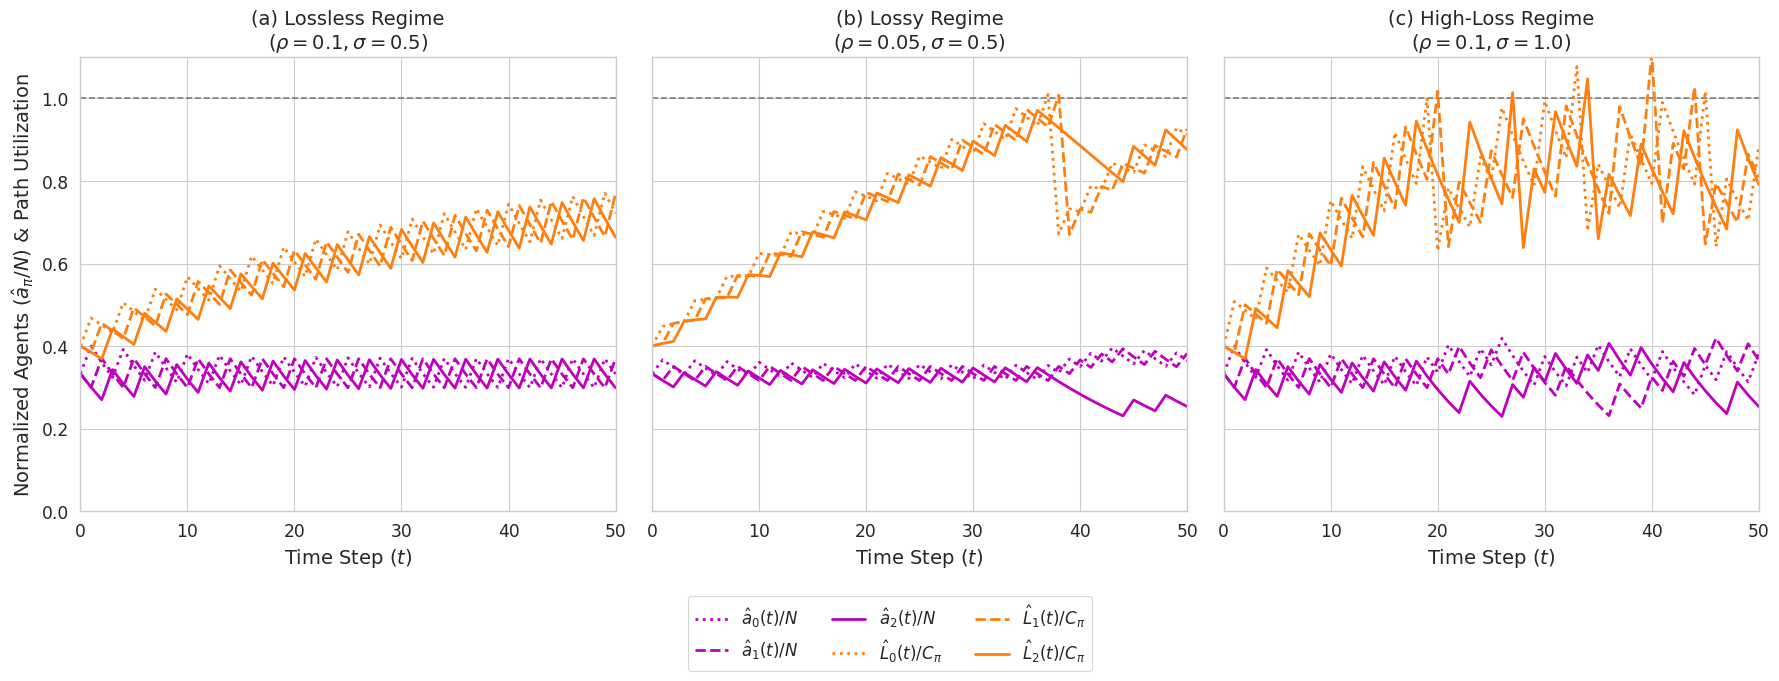

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

def run_deterministic_model(rho, sigma, P, N, C_pi, alpha, gamma, T_max):
    """
    Runs the deterministic "Expected MPCC Dynamics" model (Eq. 3).
    Returns time steps, normalized agent counts, and normalized path loads.
    """
    t_steps = np.arange(T_max)

    # State variables: Expected agents (a_hat) and Load (L_hat)
    a_hat = np.zeros((P, T_max))
    L_hat = np.zeros((P, T_max))

    # Initial conditions
    a_hat[:, 0] = N / P
    L_hat[:, 0] = 0.4 * C_pi

    # --- Main Simulation Loop ---
    for t in range(T_max - 1):
        # Identify target path (pi_min)
        pi_min_idx = np.argmin(L_hat[:, t])

        for pi in range(P):
            current_a = a_hat[pi, t]
            current_L = L_hat[pi, t]

            # --- Update Agent Dynamics (Eq. 3a)
            if pi == pi_min_idx:
                a_hat[pi, t+1] = (1 - rho) * current_a + rho * N
            else:
                a_hat[pi, t+1] = (1 - rho) * current_a

            # --- Update Load Dynamics (Eq. 3b)
            z = (N - current_a) / current_a if current_a > 0 else 0
            is_pi_min = (pi == pi_min_idx)
            is_over_capacity = (current_L > C_pi)

            if not is_over_capacity:
                if is_pi_min:
                    L_hat[pi, t+1] = (1 + rho * sigma * z) * current_L + current_a * alpha
                else:
                    L_hat[pi, t+1] = (1 - rho) * current_L + (1 - rho) * current_a * alpha
            else: # Over capacity (Congestion Event)
                if is_pi_min:
                    L_hat[pi, t+1] = (gamma + rho * sigma * z) * current_L
                else:
                    L_hat[pi, t+1] = gamma * (1 - rho) * current_L

    # Normalize for plotting
    normalized_a = a_hat / N
    normalized_L = L_hat / C_pi

    return t_steps, normalized_a, normalized_L

def plot_figure_8():
    """
    Generates Figure 8: Validation of the expected dynamics model.
    Compares the deterministic model across three stability regimes.
    """
    print("--- Generating Figure 8 (Model Validation) ---")

    # --- Parameters ---
    P = 3
    N = 1000
    C_pi = 12000
    gamma = 0.7    # Multiplicative Decrease (beta -> gamma)
    alpha = 1.0
    T_max = 51

    # Regimes defined in the paper
    param_sets = [
        {'rho': 0.1, 'sigma': 0.50},  # (a) Lossless Regime
        {'rho': 0.05, 'sigma': 0.50}, # (b) Lossy Regime
        {'rho': 0.1, 'sigma': 1.00}   # (c) High-Loss Regime
    ]

    titles = [
        "(a) Lossless Regime\n" + r"($\rho=0.1, \sigma=0.5$)",
        "(b) Lossy Regime\n" + r"($\rho=0.05, \sigma=0.5$)",
        "(c) High-Loss Regime\n" + r"($\rho=0.1, \sigma=1.0$)"
    ]

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    agent_color = 'm'
    load_color = 'tab:orange'
    linestyles = [':', '--', '-'] # Path 0, 1, 2
    line_width = 2.0

    for i, params in enumerate(param_sets):
        ax = axes[i]

        t_steps, norm_a, norm_L = run_deterministic_model(
            rho=params['rho'], sigma=params['sigma'],
            P=P, N=N, C_pi=C_pi, alpha=alpha, gamma=gamma, T_max=T_max
        )

        ax.set_title(titles[i], fontsize=14)

        # Capacity line
        ax.axhline(1.0, color='grey', linestyle='--')

        # Plot dynamics for all paths
        for pi in range(P):
            ls = linestyles[pi]
            ax.plot(t_steps, norm_a[pi, :], color=agent_color, linestyle=ls, linewidth=line_width)
            ax.plot(t_steps, norm_L[pi, :], color=load_color, linestyle=ls, linewidth=line_width)

        ax.set_xlabel('Time Step ($t$)', fontsize=14)
        ax.set_xlim(0, T_max - 1)

    axes[0].set_ylabel(r'Normalized Agents ($\hat{a}_{\pi}/N$) & Path Utilization', fontsize=14)
    axes[0].set_ylim(0.0, 1.1)

    # --- Global Legend ---
    # Proxy artists
    l_a0 = plt.Line2D([0], [0], color=agent_color, ls=linestyles[0], lw=line_width)
    l_a1 = plt.Line2D([0], [0], color=agent_color, ls=linestyles[1], lw=line_width)
    l_a2 = plt.Line2D([0], [0], color=agent_color, ls=linestyles[2], lw=line_width)
    l_u0 = plt.Line2D([0], [0], color=load_color, ls=linestyles[0], lw=line_width)
    l_u1 = plt.Line2D([0], [0], color=load_color, ls=linestyles[1], lw=line_width)
    l_u2 = plt.Line2D([0], [0], color=load_color, ls=linestyles[2], lw=line_width)

    handles = [l_a0, l_a1, l_a2, l_u0, l_u1, l_u2]
    labels = [
        r'$\hat{a}_0(t)/N$', r'$\hat{a}_1(t)/N$', r'$\hat{a}_2(t)/N$',
        r'$\hat{L}_0(t)/C_{\pi}$', r'$\hat{L}_1(t)/C_{\pi}$', r'$\hat{L}_2(t)/C_{\pi}$'
    ]

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12)

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig08_model_validation')

    plt.tight_layout()
    # bbox_inches='tight' is crucial here to include the external legend
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight')
    print(f"Figure 8 saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_8()

**Figure 9: Quantitative Illustration of the Core Trade-off**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# --- Helper Functions ---

def alpha_S_func(tau):
    """Slow-start-style additive increase (accelerating)."""
    return np.where(tau < 5, 2**tau, 1)

def alpha_1_func(tau):
    """Constant additive increase."""
    return 1

def calculate_alpha_hat_p(alpha_func, rho, P, num_terms=30):
    """Calculates the expected additive increase per path rank."""
    alpha_hat = np.zeros(P)
    term_const = 1 - (1 - rho)**(P - 1)

    if term_const == 0: return np.ones(P) * alpha_func(0)

    for p_rank in range(P):
        series_sum = sum(
            (1 - rho)**(k * (P - 1)) * alpha_func(P * k + p_rank)
            for k in range(num_terms)
        )
        alpha_hat[p_rank] = term_const * series_sum
    return alpha_hat

def get_equilibrium_context(rho, sigma, P, N, C_pi, alpha_func):
    """Calculates equilibrium state variables for a given parameter set."""
    # 1. Agent Equilibrium
    a_hat_p = np.array([((1 - rho)**p * rho * N) / (1 - (1 - rho)**P) for p in range(P)])

    # 2. Growth Equilibrium
    alpha_hat_p = calculate_alpha_hat_p(alpha_func, rho, P)

    # 3. Extrapolation Factor
    z_rho_p = (1 - (1 - rho)**(P - 1)) / (rho * (1 - rho)**(P - 1)) if rho > 0 else float('inf')
    q_factor = 1 + rho * sigma * z_rho_p

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        common_ratio = q_factor * (1 - rho)**(P - 1)
        denominator = 1 - common_ratio

    # 4. Flow Equilibrium (Eq. 7 & 8)
    f_hat_p = np.zeros(P)
    if denominator <= 0 or abs(denominator) < 1e-9:
        f_hat_p.fill(float('inf'))
    else:
        for p_rank in range(P):
            t1 = sum((1-rho)**(p_rank-p_prime) * alpha_hat_p[p_prime] * a_hat_p[p_prime] for p_prime in range(p_rank))
            t2 = (1-rho)**p_rank * alpha_hat_p[P-1] * a_hat_p[P-1]
            t3 = q_factor * sum((1-rho)**(P-1+p_rank-p_prime) * alpha_hat_p[p_prime] * a_hat_p[p_prime] for p_prime in range(p_rank, P-1))
            f_hat_p[p_rank] = (t1 + t2 + t3) / denominator

    eq_type = 'lossless' if f_hat_p[0] <= C_pi else 'lossy'

    return {
        "eq_type": eq_type,
        "f_hat_p": f_hat_p,
        "a_hat_p": a_hat_p,
        "alpha_hat_p": alpha_hat_p,
        "common_ratio": common_ratio
    }

def calculate_metrics(ctx, rho, sigma, P, N, C_pi, gamma, alpha_func):
    """Calculates Change in Convergence (Delta Gamma) relative to baseline."""
    C = P * C_pi
    alpha_max = np.max([alpha_func(tau) for tau in range(10)])
    baseline_gamma = (gamma * C) / (C + alpha_max * N)

    # Calculate Gamma_MPCC
    if ctx['eq_type'] == 'lossless':
        if ctx['f_hat_p'][0] > 0:
            gamma_mpcc = ctx['f_hat_p'][-1] / ctx['f_hat_p'][0]
        else:
            gamma_mpcc = 0
    else: # Lossy Regime
        sum_partial = sum(ctx['alpha_hat_p'][:-1])
        sum_all = sum_partial + ctx['alpha_hat_p'][-1]
        a_last = ctx['a_hat_p'][-1]

        if abs(sigma - 1.0) > 1e-6:  # sigma != 1
            lambda_mpcc = ctx['common_ratio'] - 1 + (ctx['common_ratio'] * sum_partial + ctx['alpha_hat_p'][-1]) * a_last / C_pi
        else:  # sigma == 1
            lambda_mpcc = (1 - rho)**(1 - P) * sum_all * a_last / C_pi

        gamma_mpcc = gamma * (1 - rho)**(P-1) / (lambda_mpcc + 1)

    delta_gamma = gamma_mpcc - baseline_gamma
    return delta_gamma

def plot_figure_9a():
    """
    Generates Figure 9a: Change in Convergence vs. Responsiveness.
    Visualizes the non-monotonic relationship between migration speed and stability.
    """
    print("--- Generating Figure 9a (Convergence Trade-off) ---")

    P, gamma, N, C_pi = 3, 0.7, 1000, 12000
    alpha_funcs = {r'$\alpha_1$': alpha_1_func, r'$\alpha_S$': alpha_S_func}

    rho_vals = np.linspace(0.02, 1.0, 40)
    sigma_vals = np.linspace(0.0, 1.0, 20)

    print("Calculating trade-off surface... (this may take a minute)")
    results = {}

    for name, alpha_func in alpha_funcs.items():
        results[name] = {'lossless': {'dg':[]}, 'lossy': {'dg':[]}}

        for i, rho in enumerate(rho_vals):
            dg_lossless, dg_lossy = [], []
            for sigma in sigma_vals:
                ctx = get_equilibrium_context(rho, sigma, P, N, C_pi, alpha_func)
                dg = calculate_metrics(ctx, rho, sigma, P, N, C_pi, gamma, alpha_func)

                if ctx['eq_type'] == 'lossless':
                    dg_lossless.append(dg)
                else:
                    dg_lossy.append(dg)

            # Store min/max for the fill_between plot
            for cat, dg_list in [('lossless', dg_lossless), ('lossy', dg_lossy)]:
                if dg_list:
                    results[name][cat]['dg'].append((np.min(dg_list), np.max(dg_list)))
                else:
                    results[name][cat]['dg'].append((np.nan, np.nan))

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 7))
    colors = {'lossless': {'a1': 'purple', 'aS': 'orangered'},
              'lossy': {'a1': 'darkcyan', 'aS': 'green'}}

    for name, data in results.items():
        key = 'a1' if '1' in name else 'aS'

        min_dg, max_dg = np.array(data['lossless']['dg']).T
        min_de, max_de = np.array(data['lossy']['dg']).T

        ax.fill_between(rho_vals, min_dg, max_dg, color=colors['lossless'][key],
                        alpha=0.3, label=f'Lossless, {name}')

        ax.fill_between(rho_vals, min_de, max_de, color=colors['lossy'][key],
                        alpha=0.5, hatch='..', edgecolor='gray', label=f'Lossy, {name}')

    ax.axhline(0, color='black', linestyle=':', lw=1, label='Static Baseline')

    ax.set_ylabel(r'Change in Convergence ($\Delta\gamma$)', fontsize=14)
    ax.set_xlabel(r'Responsiveness ($\rho$)', fontsize=14)

    ax.legend(loc='upper right', fontsize=11)

    # --- Save ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig09a_convergence_tradeoff')

    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight')
    print(f"Figure 9a saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_9a()

--- Generating Figure 9a (Convergence Trade-off) ---
Calculating trade-off surface... (this may take a minute)


OverflowError: Python int too large to convert to C long

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# --- Helper Functions ---

def alpha_S_func(tau):
    """Slow-start-style additive increase. Handles array inputs."""
    return np.where(tau < 5, 2**tau, 1)

def alpha_1_func(tau):
    """Constant additive increase."""
    return 1

def calculate_alpha_hat_p(alpha_func, rho, P, num_terms=30):
    """Calculates the expected additive increase per path rank."""
    alpha_hat = np.zeros(P)
    term_const = 1 - (1 - rho)**(P - 1)

    if term_const == 0: return np.ones(P) * alpha_func(0)

    for p_rank in range(P):
        series_sum = sum(
            (1 - rho)**(k * (P - 1)) * alpha_func(P * k + p_rank)
            for k in range(num_terms)
        )
        alpha_hat[p_rank] = term_const * series_sum
    return alpha_hat

def get_equilibrium_context(rho, sigma, P, N, C_pi, alpha_func):
    """
    Calculates equilibrium state to determine if the system is in a
    Lossless or Lossy regime.
    """
    a_hat_p = np.array([((1 - rho)**p * rho * N) / (1 - (1 - rho)**P) for p in range(P)])
    alpha_hat_p = calculate_alpha_hat_p(alpha_func, rho, P)
    z_rho_p = (1 - (1 - rho)**(P - 1)) / (rho * (1 - rho)**(P - 1)) if rho > 0 else float('inf')
    q_factor = 1 + rho * sigma * z_rho_p

    # Suppress potential division warnings during intermediate calculation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        common_ratio = q_factor * (1 - rho)**(P - 1)
        denominator = 1 - common_ratio

    f_hat_p = np.zeros(P)
    if abs(denominator) < 1e-9:
        f_hat_p.fill(float('inf'))
    else:
        for p_rank in range(P):
            t1 = sum((1-rho)**(p_rank-p_prime) * alpha_hat_p[p_prime] * a_hat_p[p_prime] for p_prime in range(p_rank))
            t2 = (1-rho)**p_rank * alpha_hat_p[P-1] * a_hat_p[P-1]
            t3 = q_factor * sum((1-rho)**(P-1+p_rank-p_prime) * alpha_hat_p[p_prime] * a_hat_p[p_prime] for p_prime in range(p_rank, P-1))
            f_hat_p[p_rank] = (t1 + t2 + t3) / denominator

    eq_type = 'lossless' if f_hat_p[0] <= C_pi else 'lossy'
    return {"eq_type": eq_type}

def simulate_variance(rho, sigma, P, alpha_func, N_samples=2000, T_max=60):
    """
    Nested simulation to find the steady-state variance for fairness (eta).
    """
    cwnds = np.zeros(N_samples)
    taus = np.zeros(N_samples, dtype=int)

    for t in range(T_max):
        # Determine migration candidates
        can_migrate = (taus % P) != (P - 1)
        random_triggers = np.random.rand(N_samples)

        will_migrate = can_migrate & (random_triggers < rho)
        will_not_migrate = ~will_migrate

        next_cwnds = np.zeros(N_samples)
        next_taus = np.zeros(N_samples, dtype=int)

        # Apply Dynamics
        next_cwnds[will_migrate] = cwnds[will_migrate] * sigma
        next_taus[will_migrate] = 0

        next_cwnds[will_not_migrate] = cwnds[will_not_migrate] + alpha_func(taus[will_not_migrate])
        next_taus[will_not_migrate] = taus[will_not_migrate] + 1

        cwnds, taus = next_cwnds, next_taus

    return np.var(cwnds)

def calculate_metrics(rho, sigma, P, alpha_func):
    """Calculates Fairness (eta) metric via simulation."""
    eta_mpcc = simulate_variance(rho, sigma, P, alpha_func)
    return eta_mpcc

def plot_figure_9b():
    """
    Generates Figure 9b: Change in Fairness vs. Responsiveness.
    """
    print("--- Generating Figure 9b (Fairness Trade-off) ---")

    P, gamma, N, C_pi = 3, 0.7, 1000, 12000
    alpha_funcs = {r'$\alpha_1$': alpha_1_func, r'$\alpha_S$': alpha_S_func}

    rho_vals = np.linspace(0.02, 1.0, 40)
    sigma_vals = np.linspace(0.0, 1.0, 20)

    print("Calculating data for Fairness plot... (this will take several minutes)")
    results = {}

    for name, alpha_func in alpha_funcs.items():
        # Store results for Lossless and Lossy regimes separately
        results[name] = {'lossless': {'eta':[]}, 'lossy': {'eta':[]}}

        for i, rho in enumerate(rho_vals):
            print(f"  Processing rho = {rho:.2f} ({i+1}/{len(rho_vals)})...")
            eta_lossless, eta_lossy = [], []

            for sigma in sigma_vals:
                # Check regime type
                ctx = get_equilibrium_context(rho, sigma, P, N, C_pi, alpha_func)
                # Calculate metric
                eta = calculate_metrics(rho, sigma, P, alpha_func)

                if ctx['eq_type'] == 'lossless':
                    eta_lossless.append(eta)
                else:
                    eta_lossy.append(eta)

            # Store min/max range for the shaded plot areas
            for cat, eta_list in [('lossless', eta_lossless), ('lossy', eta_lossy)]:
                if eta_list:
                    results[name][cat]['eta'].append((np.min(eta_list), np.max(eta_list)))
                else:
                    results[name][cat]['eta'].append((np.nan, np.nan))

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 7))
    colors = {'lossless': {'a1': 'purple', 'aS': 'orangered'},
              'lossy': {'a1': 'darkcyan', 'aS': 'green'}}

    for name, data in results.items():
        key = 'a1' if '1' in name else 'aS'

        # Plot Lossless Areas
        min_eta, max_eta = np.array(data['lossless']['eta']).T
        ax.fill_between(rho_vals, min_eta, max_eta, color=colors['lossless'][key],
                        alpha=0.3, label=f'Lossless, {name}')

        # Plot Lossy Areas
        min_eta, max_eta = np.array(data['lossy']['eta']).T
        ax.fill_between(rho_vals, min_eta, max_eta, color=colors['lossy'][key],
                        alpha=0.5, hatch='..', edgecolor='gray', label=f'Lossy, {name}')

    # Formatting
    ax.set_ylabel(r'Fairness ($\eta$) [log scale]', fontsize=14)
    ax.set_xlabel(r'Responsiveness ($\rho$)', fontsize=14)
    ax.set_yscale('log')

    ax.legend(loc='upper right', fontsize=11)

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig09b_fairness_tradeoff')

    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight')
    print(f"Figure 9b saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_9b()

--- Generating Figure 9b (Fairness Trade-off) ---
Calculating data for Fairness plot... (this will take several minutes)
  Processing rho = 0.02 (1/40)...
  Processing rho = 0.05 (2/40)...
  Processing rho = 0.07 (3/40)...
  Processing rho = 0.10 (4/40)...
  Processing rho = 0.12 (5/40)...
  Processing rho = 0.15 (6/40)...
  Processing rho = 0.17 (7/40)...
  Processing rho = 0.20 (8/40)...
  Processing rho = 0.22 (9/40)...
  Processing rho = 0.25 (10/40)...
  Processing rho = 0.27 (11/40)...
  Processing rho = 0.30 (12/40)...
  Processing rho = 0.32 (13/40)...
  Processing rho = 0.35 (14/40)...
  Processing rho = 0.37 (15/40)...
  Processing rho = 0.40 (16/40)...
  Processing rho = 0.42 (17/40)...
  Processing rho = 0.45 (18/40)...
  Processing rho = 0.47 (19/40)...
  Processing rho = 0.50 (20/40)...
  Processing rho = 0.52 (21/40)...
  Processing rho = 0.55 (22/40)...
  Processing rho = 0.57 (23/40)...
  Processing rho = 0.60 (24/40)...
  Processing rho = 0.62 (25/40)...
  Processing 

OverflowError: Python int too large to convert to C long

**Figure 10: Impact of Responsiveness on Efficiency ($\epsilon$)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# --- Helper Functions ---

def alpha_1(tau):
    """Constant additive increase (alpha(tau) = 1)."""
    return 1.0

def alpha_S(tau):
    """Slow-start-style additive increase (alpha(tau) = 2^tau for tau < 5, else 1)."""
    return 2**tau if tau < 5 else 1.0

def calculate_alpha_hat(p_rank, rho, P, alpha_func):
    """
    Calculates the expected additive increase (alpha_hat) for a given path rank.
    Uses geometric series summation for efficiency.
    """
    geo_r = (1 - rho)**(P - 1)

    # Handle small rho approximation
    if abs(geo_r - 1) < 1e-10:
        return alpha_func(p_rank)

    norm = 1 - geo_r

    # Optimization: For constant alpha, the sum is just 1.0
    if alpha_func == alpha_1:
        return 1.0

    # For variable alpha (alpha_S), sum the series
    s = 0.0
    r_pow = 1.0

    # Find k_max where tau = P * k + p >= 5 (saturation point of alpha_S)
    k_max = int(np.ceil((5 - p_rank) / P))
    if k_max < 0: k_max = 0

    for k in range(k_max):
        w = norm * r_pow
        tau = P * k + p_rank
        s += w * alpha_func(tau)
        r_pow *= geo_r

    # Add the tail of the series (where alpha_func is always 1)
    s += r_pow * 1.0
    return s

def calculate_equilibrium(rho, sigma, P, N, alpha_func):
    """
    Solves the linear system for equilibrium flows (f_eq).
    Returns (flow_vector, is_valid).
    """
    # Basic validity checks
    if rho <= 0 or rho > 1 or sigma < 0 or sigma > 1:
        return None, False

    denom = 1 - (1 - rho)**P
    if abs(denom) < 1e-10:
        return None, False

    # Agent Equilibrium
    a_eq = np.array([(1 - rho)**p * rho * N / denom for p in range(P)])

    denom_z = rho * (1 - rho)**(P - 1)
    if abs(denom_z) < 1e-10:
        return None, False

    # Extrapolation factor
    z = (1 - (1 - rho)**(P - 1)) / denom_z

    # Growth Equilibrium
    alpha_hat_vec = np.array([calculate_alpha_hat(p, rho, P, alpha_func) for p in range(P)])

    # Set up the linear system A * f = b
    A = np.zeros((P, P))
    b = np.zeros(P)

    # Equation for Rank 0 (Jump): f[0] - (1 + rho*sigma*z) * f[P-1] = ...
    A[0, 0] = 1
    A[0, P - 1] = -(1 + rho * sigma * z)
    b[0] = alpha_hat_vec[P - 1] * a_eq[P - 1]

    # Equation for Rank p > 0 (Shift): f[p] - (1-rho) * f[p-1] = ...
    for p in range(1, P):
        A[p, p] = 1
        A[p, p - 1] = -(1 - rho)
        b[p] = (1 - rho) * alpha_hat_vec[p - 1] * a_eq[p - 1]

    try:
        f_eq = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, False

    # Validity check: Strictly decreasing flows (Rank 0 > Rank 1 > ...)
    if not np.all(np.diff(f_eq) < 0):
        return None, False

    return f_eq, True

def plot_figure_10():
    """
    Generates Figure 10: Change in Efficiency vs. Responsiveness.
    Compares Lossless equilibria against a Lossy baseline.
    """
    print("--- Generating Figure 10 (Efficiency Trade-off) ---")

    # --- Parameters ---
    P = 3
    N = 1000
    C_total = 36000 # Total Capacity
    gamma = 0.7     # Multiplicative decrease (beta -> gamma)

    # Parameter sweep ranges
    rho_vals = np.linspace(0.01, 1.0, 50)
    sigma_vals = np.linspace(0.0, 1.0, 50)

    # Scenarios
    alpha_funcs = [(alpha_1, 'α₁'), (alpha_S, 'α_S')]

    # --- Main Calculation Loop ---
    print("Calculating efficiency trade-offs...")
    results = {}

    for alpha_func, label in alpha_funcs:
        min_deltas = []
        max_deltas = []
        print(f"  Processing {label}...")

        for rho in rho_vals:
            current_deltas = []
            for sigma in sigma_vals:
                f_eq, is_valid = calculate_equilibrium(rho, sigma, P, N, alpha_func)

                if is_valid:
                    # Check if in Lossless regime (Max flow <= Path Capacity)
                    # Path Capacity = C_total / P
                    if f_eq[0] <= C_total / P:
                        # Efficiency (epsilon) = Min Flow / Path Capacity
                        # f_eq[-1] is min flow (Rank P-1)
                        epsilon_mpcc = (f_eq[-1] * P) / C_total
                        delta_epsilon = epsilon_mpcc - gamma
                        current_deltas.append(delta_epsilon)

            if current_deltas:
                min_deltas.append(np.min(current_deltas))
                max_deltas.append(np.max(current_deltas))
            else:
                min_deltas.append(np.nan)
                max_deltas.append(np.nan)

        results[label] = (min_deltas, max_deltas)
    print("Calculations complete.")

    # --- Theoretical Lossy Baseline ---
    rho_plot_range = np.linspace(0.01, 1.0, 200)
    lossy_epsilon_mpcc = gamma * (1 - rho_plot_range)**(P - 1)
    delta_eps_lossy_line = lossy_epsilon_mpcc - gamma

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot filled regions for lossless cases
    ax.fill_between(rho_vals, results['α₁'][0], results['α₁'][1],
                    color='purple', alpha=0.5, label=r'Lossless, $\alpha_1$')
    ax.fill_between(rho_vals, results['α_S'][0], results['α_S'][1],
                    color='orange', alpha=0.5, label=r'Lossless, $\alpha_S$')

    # Plot dashed line for lossy regime
    ax.plot(rho_plot_range, delta_eps_lossy_line, color='black',
            linestyle='--', label='Lossy Regime')

    # Plot baseline
    ax.axhline(0, color='black', linestyle='-', linewidth=1.0, label='Static Baseline')

    # Formatting
    ax.set_ylim([-0.8, 0.3])
    ax.set_xlabel(r'Responsiveness ($\rho$)', fontsize=14)
    ax.set_ylabel(r'Change in Efficiency ($\Delta\epsilon$)', fontsize=14)
    ax.legend(loc='lower left', fontsize=12)

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig10_efficiency')

    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight')
    print(f"Figure 10 saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_10()

**Figure 11: The De-synchronization Benefit**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# --- Helper Functions ---

def alpha_S_func(tau):
    """Slow-start-style additive increase. Handles array inputs."""
    return np.where(tau < 5, 2**tau, 1.0)

def alpha_1_func(tau):
    """Constant additive increase."""
    return 1.0

def calculate_alpha_hat_p(alpha_func, rho, P, num_terms=50):
    """Calculates expected additive increase per path rank."""
    alpha_hat = np.zeros(P)
    term_const = 1 - (1 - rho)**(P - 1)

    if term_const == 0: return np.ones(P) * alpha_func(0)

    for p_rank in range(P):
        series_sum = sum(
            (1 - rho)**(k * (P - 1)) * alpha_func(P * k + p_rank)
            for k in range(num_terms)
        )
        alpha_hat[p_rank] = term_const * series_sum
    return alpha_hat

def get_equilibrium_context(rho, sigma, P, N, C_pi, alpha_func):
    """
    Calculates equilibrium state to determine if the system is in a
    Lossless or Lossy regime.
    """
    a_hat_p = np.array([((1 - rho)**p * rho * N) / (1 - (1 - rho)**P) for p in range(P)])
    alpha_hat_p = calculate_alpha_hat_p(alpha_func, rho, P)

    z_rho_p = (1 - (1 - rho)**(P - 1)) / (rho * (1 - rho)**(P - 1)) if rho > 0 else float('inf')
    q_factor = 1 + rho * sigma * z_rho_p

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        common_ratio = q_factor * (1 - rho)**(P - 1)
        denominator = 1 - common_ratio

    if abs(denominator) < 1e-9:
        f_hat_0 = float('inf')
    else:
        # Calculate flow on rank 0
        t1 = 0
        t2 = (1 - rho)**0 * alpha_hat_p[P-1] * a_hat_p[P-1]
        t3 = q_factor * sum((1 - rho)**(P-1-p_prime) * alpha_hat_p[p_prime] * a_hat_p[p_prime] for p_prime in range(0, P-1))
        f_hat_0 = (t1 + t2 + t3) / denominator

    eq_type = 'lossless' if f_hat_0 <= C_pi else 'lossy'

    return {
        "eq_type": eq_type,
        "f_hat_0": f_hat_0,
        "a_hat_p": a_hat_p,
        "alpha_hat_p": alpha_hat_p,
        "common_ratio": common_ratio
    }

def calculate_delta_lambda(ctx, rho, sigma, P, N, C_pi, alpha_func):
    """
    Calculates Change in Loss Avoidance (Delta Lambda) relative to static baseline.
    Negative values indicate improvement (De-synchronization benefit).
    """
    C = P * C_pi

    # Baseline (Static) Loss Rate
    # If static (rho=0), agents sync up. We approximate max load based on max alpha.
    alpha_max = np.max(alpha_S_func(np.arange(10))) if alpha_func == alpha_S_func else 1.0
    baseline_lambda = (alpha_max * N) / C

    # MPCC Loss Rate
    if ctx['eq_type'] == 'lossless':
        mpcc_lambda = 0.0
    else: # Lossy
        sum_alpha_partial = sum(ctx['alpha_hat_p'][:-1])
        sum_alpha = sum_alpha_partial + ctx['alpha_hat_p'][-1]
        a_last = ctx['a_hat_p'][-1]

        if abs(sigma - 1.0) > 1e-6:  # sigma != 1
            mpcc_lambda = ctx['common_ratio'] - 1 + (ctx['common_ratio'] * sum_alpha_partial + ctx['alpha_hat_p'][-1]) * a_last / C_pi
        else:  # sigma == 1
            mpcc_lambda = (1 - rho)**(1 - P) * sum_alpha * a_last / C_pi

    return mpcc_lambda - baseline_lambda

def plot_figure_11():
    """
    Generates Figure 11: Change in Loss Avoidance vs. Responsiveness.
    Shows the 'De-synchronization Benefit' where migration reduces loss
    compared to static routing for bursty traffic.
    """
    print("--- Generating Figure 11 (De-synchronization Benefit) ---")

    # --- Parameters ---
    P, gamma, N, C_pi = 3, 0.7, 1000, 12000

    alpha_funcs = {
        r'$\alpha_1$': alpha_1_func,
        r'$\alpha_S$': alpha_S_func
    }

    rho_vals = np.linspace(0.02, 1.0, 50)
    sigma_vals = np.linspace(0.0, 1.0, 25)

    # --- Main Calculation Loop ---
    print("Calculating data... (this may take a moment)")
    results = {}

    for name, alpha_func in alpha_funcs.items():
        results[name] = {'lossless': [], 'lossy': []}

        for rho in rho_vals:
            dl_lossless, dl_lossy = [], []
            for sigma in sigma_vals:
                ctx = get_equilibrium_context(rho, sigma, P, N, C_pi, alpha_func)
                dl = calculate_delta_lambda(ctx, rho, sigma, P, N, C_pi, alpha_func)

                if ctx['eq_type'] == 'lossless':
                    dl_lossless.append(dl)
                else:
                    dl_lossy.append(dl)

            # Store range tuples
            results[name]['lossless'].append((np.min(dl_lossless), np.max(dl_lossless)) if dl_lossless else (np.nan, np.nan))
            results[name]['lossy'].append((np.min(dl_lossy), np.max(dl_lossy)) if dl_lossy else (np.nan, np.nan))

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = {'lossless': {'a1': 'darkblue', 'aS': 'darkred'},
              'lossy': {'a1': 'skyblue', 'aS': 'salmon'}}

    for name, data in results.items():
        key = 'a1' if '1' in name else 'aS'

        # Plot Lossless Region
        min_dl, max_dl = np.array(data['lossless']).T
        ax.fill_between(rho_vals, min_dl, max_dl, color=colors['lossless'][key],
                        alpha=0.5, label=f'Lossless, {name}')

        # Plot Lossy Region
        min_dl, max_dl = np.array(data['lossy']).T
        ax.fill_between(rho_vals, min_dl, max_dl, color=colors['lossy'][key],
                        alpha=0.4, label=f'Lossy, {name}')

        # Add boundary lines for clarity in Lossy regions
        ax.plot(rho_vals, min_dl, color=colors['lossy'][key], linestyle=':', lw=1.5)
        ax.plot(rho_vals, max_dl, color=colors['lossy'][key], linestyle='--', lw=1.5)

    # --- Styling ---
    ax.axhline(0, color='black', linestyle=':', lw=1, label='Static Baseline')

    ax.set_ylabel(r'Change in Loss Avoidance ($\Delta \lambda$)', fontsize=14)
    ax.set_xlabel(r'Responsiveness ($\rho$)', fontsize=14)
    ax.set_xlim(0, 1)

    ax.legend(loc='best', fontsize=11)

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig11_desync_benefit')

    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight')
    print(f"Figure 11 saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_11()

**Figure 12: The Phase Transition in Path-Aware Dynamics**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("white") # Heatmaps often look better without gridlines

def simulate_stochastic_dynamics(N, P, steps, rho, sigma, C_total, gamma=0.5, k_subset=None):
    """
    Simulates the stochastic agent-based model to capture de-synchronization effects.
    """
    if k_subset is None:
        k_subset = P

    # Derived parameters
    C_path = C_total / P

    # Initialization
    agents_path = np.random.randint(0, P, size=N)
    agents_window = np.ones(N) * (C_total / N) * 0.5
    agents_tau = np.zeros(N)

    utilization_history = np.zeros((P, steps))

    for t in range(steps):
        # 1. Calculate Load per Path
        path_loads = np.bincount(agents_path, weights=agents_window, minlength=P)
        utilization_history[:, t] = path_loads / C_path

        # Add noise for tie-breaking
        noisy_loads = path_loads + np.random.normal(0, 1e-3, P)

        # 2. Identify Targets (TRUE Probing Logic)

        # Vectorized Probing: Each agent samples k paths
        k_curr = min(k_subset, P)

        if k_curr == P:
            # Global Knowledge (Original logic): Every agent targets the global minimum
            best_path_index = np.argmin(noisy_loads)
            specific_best_path = np.full(N, best_path_index, dtype=int)

            # Migration Condition: Migrate if current path is NOT the best path
            is_better_path_found = (agents_path != best_path_index)

        else:
            # Local Probing: Each agent samples k paths independently
            # Generate random probe indices for all agents: Shape (N, k_curr)
            probes = np.random.randint(0, P, size=(N, k_curr))

            # Look up the noisy loads for these probes
            probe_loads = noisy_loads[probes]

            # Each agent identifies the best path *within their specific probe set*
            local_best_indices = np.argmin(probe_loads, axis=1)

            # Map back to the global Path ID (0..P)
            specific_best_path = probes[np.arange(N), local_best_indices]

            # Migration Condition: Found path is strictly better than current path
            current_path_loads = noisy_loads[agents_path]
            found_path_loads = noisy_loads[specific_best_path]
            is_better_path_found = found_path_loads < current_path_loads


        # 3. Migration Logic
        # Apply Responsiveness (rho)
        migration_decisions = np.random.random(N) < rho

        # Combined condition
        migrating_agents = is_better_path_found & migration_decisions

        # Apply Migration
        agents_window[migrating_agents] *= sigma
        agents_tau[migrating_agents] = 0
        agents_path[migrating_agents] = specific_best_path[migrating_agents]

        # 4. Congestion Control (Loss and Increase logic remains unchanged)
        current_path_loads = np.bincount(agents_path, weights=agents_window, minlength=P)
        overloaded_paths = np.where(current_path_loads > C_path)[0]

        # Fast boolean lookup for overloaded status
        is_overloaded_path = np.zeros(P, dtype=bool)
        is_overloaded_path[overloaded_paths] = True
        agents_on_overloaded = is_overloaded_path[agents_path]

        # Multiplicative Decrease (Loss)
        agents_window[agents_on_overloaded] *= gamma
        agents_tau[agents_on_overloaded] = 0

        # Additive Increase (approx. alpha=1 for stochastic model)
        agents_window[~agents_on_overloaded] += 1.0
        agents_tau[~agents_on_overloaded] += 1

    return utilization_history

def plot_figure_12():
    """
    Generates Figure 12: Phase Transition Heatmaps.
    Visualizes the shift from coherent oscillation (Low P) to noise (High P).
    """
    print("--- Generating Figure 12 (Phase Transition Heatmaps) ---")

    # Parameters
    N_AGENTS = 2000
    STEPS = 150
    RHO = 0.3
    SIGMA = 0.5
    TOTAL_CAP = 50000
    GAMMA = 0.5

    # NEW PARAMETER: Limited Probing (k=5)
    K_PROBE = 5

    print(f"  Running Low-Diversity Simulation (P=5, k={K_PROBE})...")
    util_low_p = simulate_stochastic_dynamics(
        N=N_AGENTS, P=5, steps=STEPS, rho=RHO, sigma=SIGMA,
        C_total=TOTAL_CAP, gamma=GAMMA, k_subset=K_PROBE
    )

    print(f"  Running High-Diversity Simulation (P=50, k={K_PROBE})...")
    util_high_p = simulate_stochastic_dynamics(
        N=N_AGENTS, P=50, steps=STEPS, rho=RHO, sigma=SIGMA,
        C_total=TOTAL_CAP, gamma=GAMMA, k_subset=K_PROBE
    )

    # --- Plotting ---
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    cmap = 'inferno'
    vmin, vmax = 0.0, 1.5

    # Plot 1: Low P
    im1 = axes[0].imshow(util_low_p, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    axes[0].set_title(f"Low Path Diversity ($P=5$, $k={K_PROBE}$): Coherent Oscillation", fontsize=14)
    axes[0].set_ylabel("Path Index", fontsize=12)

    # Only show x-labels on bottom plot
    axes[0].set_xticklabels([])

    # Plot 2: High P
    im2 = axes[1].imshow(util_high_p, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    axes[1].set_title(f"High Path Diversity ($P=50$, $k={K_PROBE}$): De-synchronization (Fractured Herd)", fontsize=14)
    axes[1].set_ylabel("Path Index", fontsize=12)
    axes[1].set_xlabel("Time Step ($t$)", fontsize=12)

    # Shared Colorbar
    cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.04)
    cbar.set_label(r'Path Utilization ($\hat{L}_{\pi} / C_{\pi}$)', fontsize=12)
    # Mark capacity line
    cbar.ax.plot([0, 1], [1.0, 1.0], 'w-', linewidth=2)

    # fig.suptitle(rf"The Phase Transition: From Synchronization to Noise ($N={N_AGENTS}, \rho={RHO}$) - Probing Model", fontsize=16)

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig12_phase_transition')

    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight')
    print(f"Figure 12 (Fixed) saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_12()

**Figure 13: The Cost of Scale under Bounded Probing ($k=5$)**

--- Generating Figure 13 (Envelope Plot) ---
Simulating with Sub-selection (k=5)...
  P=2: Amplitude=0.183
  P=5: Amplitude=0.320
  P=10: Amplitude=0.429
  P=20: Amplitude=0.526
  P=40: Amplitude=0.592
  P=60: Amplitude=0.639
  P=80: Amplitude=0.670
  P=100: Amplitude=0.696
Figure 13 saved to: figures/fig13_envelope_plot.pdf


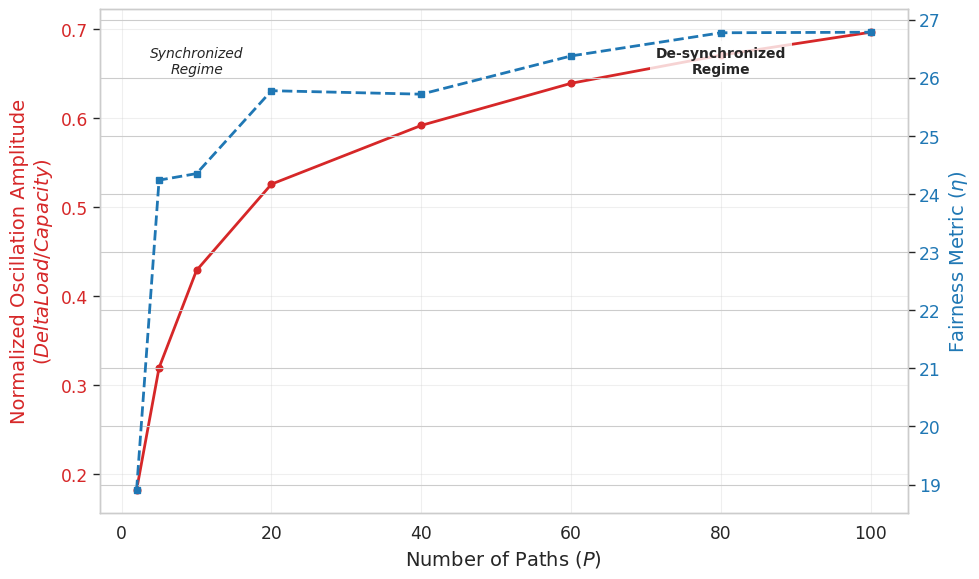

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Plotting Style Setup ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

def run_simulation(P, steps=300, rho=0.1, sigma=0.5, agents_per_path=100, k_subset=5):
    """
    Runs simulation with TRUE 'k-subset' probing to match the paper's claims.
    """
    N = P * agents_per_path
    C_total = N * 10
    C_path = C_total / P

    agents_path = np.random.randint(0, P, size=N)
    agents_window = np.ones(N) * 5.0

    transient_cutoff = 100
    history_spread = []
    history_fairness = []

    for t in range(steps):
        # 1. Calc Loads
        path_loads = np.bincount(agents_path, weights=agents_window, minlength=P)
        utilization = path_loads / C_path

        if t > transient_cutoff:
            spread = np.max(utilization) - np.min(utilization)
            history_spread.append(spread)
            history_fairness.append(np.var(agents_window))

        # 2. Identify Targets (True Probing Logic)
        # Add noise to break ties in comparison
        noisy_loads = path_loads + np.random.normal(0, C_path * 0.01, P)

        # Generate random probe indices for all agents: Shape (N, k_subset)
        # Each row represents the subset of paths a single agent "sees"
        probes = np.random.randint(0, P, size=(N, k_subset))

        # Look up the noisy loads for these probes
        probe_loads = noisy_loads[probes]  # Shape (N, k_subset)

        # Each agent identifies the best path *within their specific probe set*
        local_best_indices = np.argmin(probe_loads, axis=1)

        # Map the local index (0..k) back to the global Path ID (0..P)
        specific_best_path = probes[np.arange(N), local_best_indices]

        # 3. Migration Logic
        # Compare the load of the agent's CURRENT path to the path they FOUND
        current_path_loads = noisy_loads[agents_path]
        found_path_loads = noisy_loads[specific_best_path]

        # Agent considers moving ONLY if the found path is strictly better
        is_better_path_found = found_path_loads < current_path_loads

        # Apply Responsiveness (rho)
        # Migrate if: (Found Better Path) AND (Dice Roll < rho)
        should_migrate = is_better_path_found & (np.random.random(N) < rho)

        migrating_indices = np.where(should_migrate)[0]

        # Move agents
        if len(migrating_indices) > 0:
            # Apply Penalties to migrants
            agents_window[migrating_indices] *= sigma
            # Update locations
            agents_path[migrating_indices] = specific_best_path[migrating_indices]

        # 4. Congestion Control
        current_loads = np.bincount(agents_path, weights=agents_window, minlength=P)
        overloaded_paths = np.where(current_loads > C_path)[0]

        is_overloaded = np.zeros(P, dtype=bool)
        is_overloaded[overloaded_paths] = True
        agents_in_loss = is_overloaded[agents_path]

        agents_window[agents_in_loss] *= 0.5
        agents_window[~agents_in_loss] += 1.0

    return np.mean(history_spread), np.mean(history_fairness)

def plot_figure_13():
    """
    Generates Figure 13: The Benefit of Scale (Envelope Plot).
    Shows how instability decays as path diversity increases under limited information.
    """
    print("--- Generating Figure 13 (Envelope Plot) ---")

    # P_values going higher to emphasize the tail
    P_values = [2, 5, 10, 20, 40, 60, 80, 100]
    seeds_per_p = 5
    K_SUBSET = 5

    results_spread = []
    results_fairness = []

    print(f"Simulating with Sub-selection (k={K_SUBSET})...")

    for P in P_values:
        s_runs = []
        f_runs = []
        for _ in range(seeds_per_p):
            s, f = run_simulation(P, rho=0.2, sigma=0.5, k_subset=K_SUBSET)
            s_runs.append(s)
            f_runs.append(f)

        avg_s = np.mean(s_runs)
        avg_f = np.mean(f_runs)
        results_spread.append(avg_s)
        results_fairness.append(avg_f)
        print(f"  P={P}: Amplitude={avg_s:.3f}")

    # --- PLOTTING ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Red Line (Amplitude)
    color_amp = '#D62728' # tab:red
    ax1.set_xlabel('Number of Paths ($P$)', fontsize=14)
    ax1.set_ylabel('Normalized Oscillation Amplitude\n$(Delta Load / Capacity)$', color=color_amp, fontsize=14)
    ax1.plot(P_values, results_spread, color=color_amp, marker='o', linewidth=2, label='Oscillation Amplitude')
    ax1.tick_params(axis='y', labelcolor=color_amp)
    ax1.grid(True, alpha=0.3)

    # Blue Line (Fairness)
    ax2 = ax1.twinx()
    color_fair = '#1F77B4' # tab:blue
    ax2.set_ylabel(r'Fairness Metric ($\eta$)', color=color_fair, fontsize=14)
    ax2.plot(P_values, results_fairness, color=color_fair, marker='s', linestyle='--', linewidth=2, label='Fairness Metric')
    ax2.tick_params(axis='y', labelcolor=color_fair)

    # Dynamic placement for annotations based on data
    y_lim = ax1.get_ylim()[1]
    ax1.text(10, y_lim*0.9, "Synchronized\nRegime", ha='center', fontsize=10, style='italic',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax1.text(80, y_lim*0.9, "De-synchronized\nRegime", ha='center', fontsize=10, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # --- Save Output ---
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_filename = os.path.join(output_dir, 'fig13_envelope_plot')

    plt.tight_layout()
    plt.savefig(f'{base_filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{base_filename}.pdf', dpi=300, bbox_inches='tight')
    print(f"Figure 13 saved to: {base_filename}.pdf")

    plt.show()

if __name__ == "__main__":
    plot_figure_13()